<a href="https://colab.research.google.com/github/MarcoFratta/TennisPlayersFingerprint/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Initialization: ATP Playing Style Clustering

## Project Overview

This project aims to extract **playing style fingerprints** from tennis players and cluster them into distinct style categories using unsupervised machine learning techniques.

### Project Concept:

- **Dataset**: Match Charting Project (Jeff Sackmann)  
- **Objective**: Extract player playing style fingerprints and cluster players by style
- **Methodology**: Autoencoder-based feature extraction + clustering algorithms

### Approach:

1. **Style Fingerprint Extraction**: Create a vector of features that describes each player's playing style
2. **Dimensionality Reduction**: Use an autoencoder to compress the high-dimensional fingerprint into a meaningful latent representation
3. **Player Clustering**: Apply clustering algorithms to group players with similar playing characteristics
4. **Style Discovery**: Identify and visualize distinct tennis playing styles from the clustered data

The goal is to automatically discover and classify different tennis playing approaches (e.g., Big Server, All-Court Player, Counter Puncher) by analyzing player behavior patterns in match statistics.

# Library Imports

In [110]:
!pip install pandas matplotlib seaborn scikit-learn --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from collections import defaultdict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import plotly.graph_objects as go
from scipy.spatial import ConvexHull


# Funzioni utili

In [2]:
def show_side_by_side(plot_functions, titles=None, figsize=(5, 4)):
    n = len(plot_functions)
    fig, axes = plt.subplots(1, n, figsize=(figsize[0]*n, figsize[1]), squeeze=False)

    for i, plot_fn in enumerate(plot_functions):
        plot_fn(axes[0, i])
        if titles:
            axes[0, i].set_title(titles[i])

    plt.tight_layout()
    plt.show()


# Dataset Loading

[Match Charting Project Dataset (CSV)](https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-m-points-2023.csv)

The **Match Charting Project** is a comprehensive tennis dataset created by Jeff Sackmann that contains detailed point-by-point statistics from professional tennis matches. This dataset is widely regarded as one of the most detailed and accurate sources of tennis match data available.

## Key Features:

- **Comprehensive Coverage**: Includes both ATP (men's) and WTA (women's) professional tennis matches
- **Detailed Statistics**: Point-by-point data with shot-by-shot breakdowns including:
  - Serve statistics (first serve, second serve, aces, double faults)
  - Rally analysis (rally length, winners, unforced errors)
  - Shot direction and placement
  - Return depth and positioning
  - Shot types (groundstrokes, volleys, slices, drop shots)
  - Net play statistics

- **Temporal Range**: Data spans multiple years, allowing for analysis of player evolution and style changes over time
- **Surface Variety**: Matches from all major court surfaces (Hard, Clay, Grass)
- **Tournament Coverage**: Includes data from Grand Slams, Masters 1000, and other professional tournaments

This dataset provides the foundation for advanced tennis analytics, enabling researchers and analysts to study playing patterns, player styles, and tactical approaches in unprecedented detail.


In [104]:
!wget https://github.com/JeffSackmann/tennis_MatchChartingProject/archive/master.zip
!unzip -o master.zip

m_matches_path = "tennis_MatchChartingProject-master/charting-m-matches.csv"
w_matches_path = "tennis_MatchChartingProject-master/charting-w-matches.csv"


--2025-09-26 09:49:01--  https://github.com/JeffSackmann/tennis_MatchChartingProject/archive/master.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/JeffSackmann/tennis_MatchChartingProject/zip/refs/heads/master [following]
--2025-09-26 09:49:01--  https://codeload.github.com/JeffSackmann/tennis_MatchChartingProject/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.2’

master.zip.2            [          <=>       ]  52.46M  5.04MB/s    in 11s     

2025-09-26 09:49:12 (4.68 MB/s) - ‘master.zip.2’ saved [55014314]

Archive:  master.zip
36f39803851d936a96f97ffeae836bd85cb0ac47
  inflating: tenn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

m_matches = pd.read_csv(m_matches_path)
w_matches = pd.read_csv(w_matches_path)

# Dataset cleaning
- Number of matches
- Number of distinctplayers

In [5]:
print(f"Number of ATP matches: {m_matches['match_id'].nunique()}")
print(f"Number of WTA matches: {w_matches['match_id'].nunique()}")

male_players = pd.unique(m_matches[['Player 1', 'Player 2']].values.ravel('K'))
female_players = pd.unique(w_matches[['Player 1', 'Player 2']].values.ravel('K'))

print(f"Number of ATP players: {len(male_players)}")
print(f"Number of WTA players: {len(female_players)}")

Number of ATP matches: 6638
Number of WTA matches: 3484
Number of ATP players: 954
Number of WTA players: 626


Now we show the Surface distribution

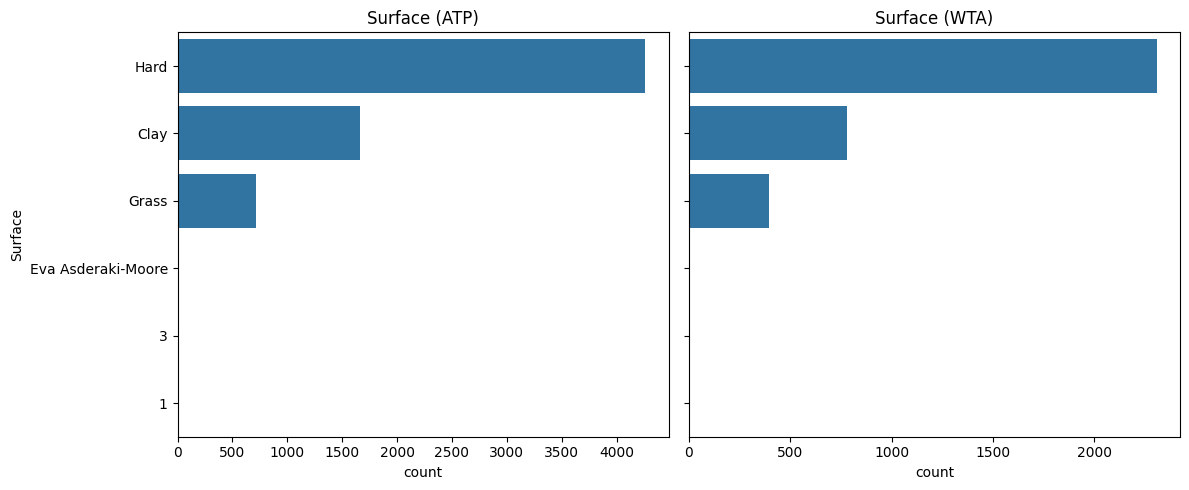

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.countplot(ax=axes[0], data=m_matches, y='Surface', order=m_matches['Surface'].value_counts().index)
axes[0].set_title("Surface (ATP)")

sns.countplot(ax=axes[1], data=w_matches, y='Surface', order=w_matches['Surface'].value_counts().index)
axes[1].set_title("Surface (WTA)")

plt.tight_layout()
plt.show()


Some match has a wrong Surface, we can remove them

In [7]:
print(f"Number of ATP surfaces: {m_matches['Surface'].unique()}")
before = len(m_matches)
m_matches = m_matches[m_matches['Surface'].isin(['Clay', 'Grass', 'Hard'])]
afater = len(m_matches)
print(f"Number of ATP surfaces: {m_matches['Surface'].unique()}")
print(f"Removed {before - afater} rows from ATP matches")

print(f"Number of WTA surfaces: {w_matches['Surface'].unique()}")
before = len(w_matches)
w_matches = w_matches[w_matches['Surface'].isin(['Clay', 'Grass', 'Hard'])]
afater = len(w_matches)
print(f"Number of WTA surfaces: {w_matches['Surface'].unique()}")
print(f"Removed {before - afater} rows from WTA matches")

print(f"Number of ATP matches {len(m_matches)}")
print(f"Number of WTA matches {len(w_matches)}")

Number of ATP surfaces: ['Hard' 'Grass' 'Clay' 'Eva Asderaki-Moore' '3']
Number of ATP surfaces: ['Hard' 'Grass' 'Clay']
Removed 2 rows from ATP matches
Number of WTA surfaces: ['Grass' 'Clay' 'Hard' 'Eva Asderaki-Moore' '1' '3']
Number of WTA surfaces: ['Grass' 'Clay' 'Hard']
Removed 9 rows from WTA matches
Number of ATP matches 6637
Number of WTA matches 3482


Now we plot again the Surfaces

<Figure size 640x480 with 0 Axes>

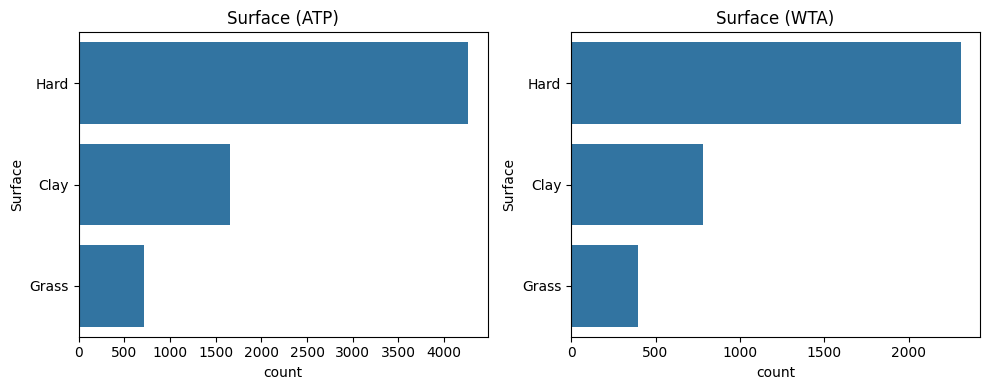

In [8]:
plt.tight_layout()
plt.show()
show_side_by_side(
    plot_functions=[
        lambda ax: sns.countplot(ax=ax, data=m_matches, y='Surface', order=m_matches['Surface'].value_counts().index),
        lambda ax: sns.countplot(ax=ax, data=w_matches, y='Surface', order=w_matches['Surface'].value_counts().index)
    ],
    titles=["Surface (ATP)", "Surface (WTA)"]
)


Now we show the number of different Tournaments

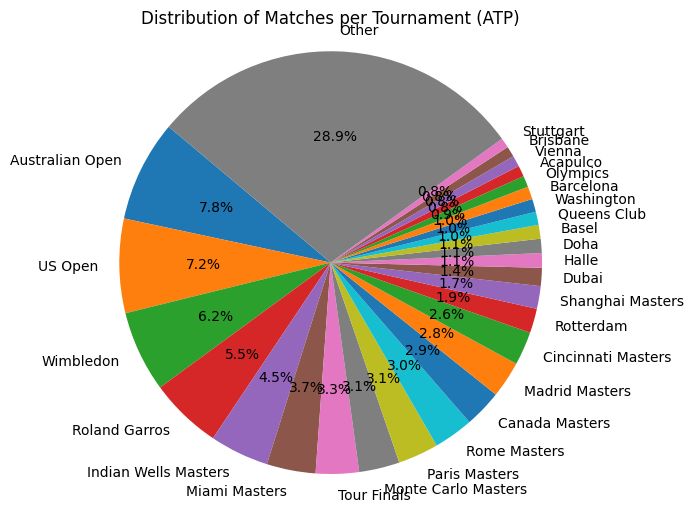

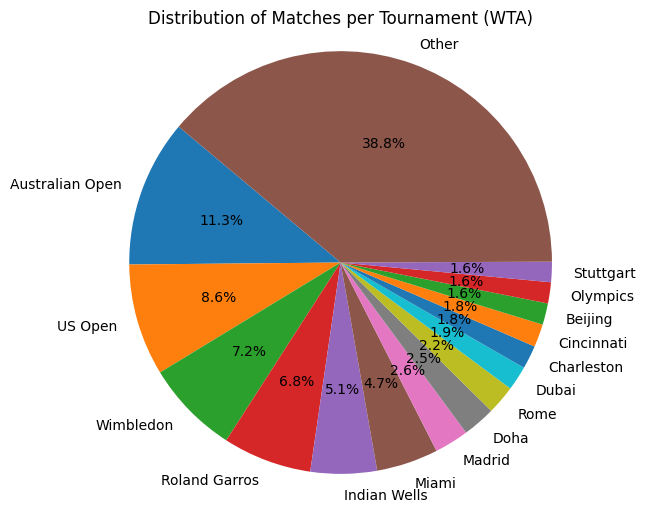

In [9]:
def plot_tournament_pie(df, title, threshold=50):
    # Count matches per tournament
    counts = df['Tournament'].value_counts()

    # Group small categories into "Other"
    main = counts[counts >= threshold]
    other_sum = counts[counts < threshold].sum()
    if other_sum > 0:
        main['Other'] = other_sum

    plt.figure(figsize=(6, 6))
    plt.pie(main.values, labels=main.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Plot for male matches (ATP)
plot_tournament_pie(m_matches, "Distribution of Matches per Tournament (ATP)")

# Plot for female matches (WTA)
plot_tournament_pie(w_matches, "Distribution of Matches per Tournament (WTA)")


# Load stats for each player
Now we load the stats about each point of the matches. Most of them are differentiated in **categories**. For example the *ServeBasics* dataset, differentiate the stats beteween **First Serve** and **Second Serve**. Each dataset has is own differentiation that will be explained below.

We want to encode the player style so we can remove some fields making some assumptions:
- **Surface**: We assume that a player do not change his playing style so drastically when the surface changes.
- **Date**: We assume that a player tends to have the same playing style through his entire career (Not always true).
- **Time**: We assume that a player keeps his playing style in both short and long matches.
- **Court**: The court should not affect the playing style.
- **Umpire**
- **Best of**: (Same as time)
- **Final TB**
- **Charted by**
- **Year**


In [10]:


def load_categorized_stats_files(gender='m', base_path='tennis_MatchChartingProject-master'):
    """
    Load pre-aggregated stats files with proper row categorization handling

    Args:
        gender: 'm' for men, 'w' for women

    Returns:
        Dictionary with processed DataFrames for each stats category
    """
    stats_data = {}

    # Overview: Only "Total" rows (no set-by-set breakdown)
    # We do not want set-by-set info
    try:
        overview_df = pd.read_csv(f'{base_path}/charting-{gender}-stats-Overview.csv')
        overview_df['row'] = overview_df['set']
        overview_df.drop(columns=['set'], inplace=True)
        stats_data['overview'] = overview_df[overview_df['row'] == 'Total'].copy()
        print(f"Overview: {len(stats_data['overview'])} total records loaded")
    except FileNotFoundError:
        print(f"Overview file not found for gender {gender}")
        stats_data['overview'] = pd.DataFrame()

    # ServeBasics: Differentiate 1st and 2nd serve (exclude "Total")
    try:
        serve_basics_df = pd.read_csv(f'{base_path}/charting-{gender}-stats-ServeBasics.csv')
        stats_data['serve_basics'] = serve_basics_df[serve_basics_df['row'].isin(['1', '2'])].copy()
        print(f"ServeBasics: {len(stats_data['serve_basics'])} records (1st/2nd serve split)")
    except FileNotFoundError:
        print(f"ServeBasics file not found for gender {gender}")
        stats_data['serve_basics'] = pd.DataFrame()

    # Rally: Keep rally length differentiation (exclude "Total")
    try:
        rally_df = pd.read_csv(f'{base_path}/charting-{gender}-stats-Rally.csv')
        rally_categories = ['1-3', '4-6', '7-9', '10']
        rally_df['player'] = rally_df['server']
        rally_df.drop(columns=['server'], inplace=True)
        stats_data['rally'] = rally_df[rally_df['row'].isin(rally_categories)].copy()
        print(f"Rally: {len(stats_data['rally'])} records across rally lengths {rally_categories}")
    except FileNotFoundError:
        print(f"Rally file not found for gender {gender}")
        stats_data['rally'] = pd.DataFrame()

    # ShotDirection: Keep shot type differentiation (f, b, s, etc.)
    try:
        shot_dir_df = pd.read_csv(f'{base_path}/charting-{gender}-stats-ShotDirection.csv')
        # Exclude "Total" to keep shot type breakdown
        shot_types = shot_dir_df['row'].unique()
        shot_types = [t for t in shot_types if t != 'Total']
        stats_data['shot_direction'] = shot_dir_df[shot_dir_df['row'].isin(shot_types)].copy()
        print(f"ShotDirection: {len(stats_data['shot_direction'])} records across shot types {shot_types}")
    except FileNotFoundError:
        print(f"ShotDirection file not found for gender {gender}")
        stats_data['shot_direction'] = pd.DataFrame()

    # ReturnOutcomes: Keep all differentiation (v1st/v2nd, fh/bh, court positions, game scores)
    try:
        return_outcomes_df = pd.read_csv(f'{base_path}/charting-{gender}-stats-ReturnOutcomes.csv')
        # Exclude "Total" to keep detailed breakdown
        return_categories = return_outcomes_df['row'].unique()
        stats_data['return_outcomes'] = return_outcomes_df[return_outcomes_df['row'].isin(return_categories)].copy()
        print(f"ReturnOutcomes: {len(stats_data['return_outcomes'])} records across categories {return_categories[:10]}...")
    except FileNotFoundError:
        print(f"ReturnOutcomes file not found for gender {gender}")
        stats_data['return_outcomes'] = pd.DataFrame()

    # ReturnDepth: Keep all differentiation (return depth categories)
    try:
        return_depth_df = pd.read_csv(f'{base_path}/charting-{gender}-stats-ReturnDepth.csv')
        # Exclude "Total" to keep detailed breakdown
        return_depth_categories = return_depth_df['row'].unique()
        return_depth_categories = [t for t in return_depth_categories if t != 'Total']
        stats_data['return_depth'] = return_depth_df[return_depth_df['row'].isin(return_depth_categories)].copy()
        print(f"ReturnDepth: {len(stats_data['return_depth'])} records across categories {return_depth_categories}")
    except FileNotFoundError:
        print(f"ReturnDepth file not found for gender {gender}")
        stats_data['return_depth'] = pd.DataFrame()

    # ShotTypes: Keep differentiation
    try:
        shot_types_df = pd.read_csv(f'{base_path}/charting-{gender}-stats-ShotTypes.csv')
        shot_type_categories = shot_types_df['row'].unique()
        stats_data['shot_types'] = shot_types_df[shot_types_df['row'].isin(shot_type_categories)].copy()
        print(f"ShotTypes: {len(stats_data['shot_types'])} records across types {shot_type_categories}")
    except FileNotFoundError:
        print(f"ShotTypes file not found for gender {gender}")
        stats_data['shot_types'] = pd.DataFrame()

    # SnV: Keep serve & volley differentiation
    try:
        snv_df = pd.read_csv(f'{base_path}/charting-{gender}-stats-SnV.csv')
        snv_categories = snv_df['row'].unique()
        stats_data['snv'] = snv_df.copy()
        print(f"SnV: {len(stats_data['snv'])} records across categories {snv_categories}")
    except FileNotFoundError:
        print(f"SnV file not found for gender {gender}")
        stats_data['snv'] = pd.DataFrame()

    # ServeDirection: Keep 1st/2nd serve differentiation
    try:
        serve_dir_df = pd.read_csv(f'{base_path}/charting-{gender}-stats-ServeDirection.csv')
        serve_dir_categories = serve_dir_df['row'].unique()
        serve_dir_categories = [t for t in serve_dir_categories if t != 'Total']
        stats_data['serve_direction'] = serve_dir_df[serve_dir_df['row'].isin(serve_dir_categories)].copy()
        print(f"ServeDirection: {len(stats_data['serve_direction'])} records for 1st/2nd serves")
        print("ServeDirection row values: '1' = first serve, '2' = second serve")
    except FileNotFoundError:
        print(f"ServeDirection file not found for gender {gender}")
        stats_data['serve_direction'] = pd.DataFrame()

    # ServeInfluence: Keep 1st/2nd serve differentiation
    try:
        serve_inf_df = pd.read_csv(f'{base_path}/charting-{gender}-stats-ServeInfluence.csv')
        serve_inf_categories = serve_inf_df['row'].unique()
        stats_data['serve_influence'] = serve_inf_df.copy()
        print(f"ServeInfluence: {len(stats_data['serve_influence'])} records for 1st/2nd serves")
        print("ServeInfluence columns: won_1+ to won_10+ = % points won when rally reaches 1+ to 10+ shots")
        print("ServeInfluence row values: '1' = first serve influence, '2' = second serve influence")
    except FileNotFoundError:
        print(f"ServeInfluence file not found for gender {gender}")
        stats_data['serve_influence'] = pd.DataFrame()

    # ShotDirOutcome: Keep differentiation
    try:
        shot_dir_outcome_df = pd.read_csv(f'{base_path}/charting-{gender}-stats-ShotDirOutcomes.csv')
        if not shot_dir_outcome_df.empty:
            shot_dir_outcome_categories = shot_dir_outcome_df['row'].unique()
            stats_data['shot_dir_outcome'] = shot_dir_outcome_df.copy()
            print(f"ShotDirOutcome: {len(stats_data['shot_dir_outcome'])} records")
            print("ShotDirOutcome contains shot direction vs outcome correlations")
        else:
            stats_data['shot_dir_outcome'] = pd.DataFrame()
    except FileNotFoundError:
        print(f"ShotDirOutcome file not found for gender {gender}")
        stats_data['shot_dir_outcome'] = pd.DataFrame()

    return stats_data

We load both the male and female stats

In [11]:
m_stats = load_categorized_stats_files(gender='m')
w_stats = load_categorized_stats_files(gender='w')

Overview: 13262 total records loaded
ServeBasics: 26519 records (1st/2nd serve split)
Rally: 26355 records across rally lengths ['1-3', '4-6', '7-9', '10']
ShotDirection: 39374 records across shot types ['F', 'B', 'S']
ReturnOutcomes: 271988 records across categories ['Total' 'v1st' 'v2nd' 'fh' 'bh' 'gs' 'sl' 'D' 'A' '4']...
ReturnDepth: 223689 records across categories ['v1st', 'v2nd', 'fh', 'bh', 'gs', 'sl', 'D', 'A', '4', '5', '6', '4D', '4A', '5D', '5A', '6D', '6A']
ShotTypes: 308946 records across types ['Total' 'Fside' 'Bside' 'Fgs' 'Bgs' 'Base' 'Net' 'Gs' 'Sl' 'Dr' 'Vo' 'Ov'
 'Hv' 'F' 'B' 'R' 'Y' 'V' 'Z' 'O' 'H' 'Lo' 'U' 'L' 'M' 'S' 'Sw' 'P' 'J'
 'I' 'K' 'T']
SnV: 44578 records across categories ['SnV' 'SnV1st' 'nonSnV' 'nonSnV1st' 'nonSnV2nd' 'SnV2nd']
ServeDirection: 26519 records for 1st/2nd serves
ServeDirection row values: '1' = first serve, '2' = second serve
ServeInfluence: 26527 records for 1st/2nd serves
ServeInfluence columns: won_1+ to won_10+ = % points won when rall

# Data Aggregation
So now we have a dataset containing raw data about each player matches.
We want to aggregate those matches data to have one single row for each player for a specific category. Since each category is subdivided into multiple fine grained categories, we should create not just one single row for each player but a number of rows depending on the different number of values that the `row` column can have in a specific category dataset.  Example:
> The serve_basics category has the row column that can either have the value of `1` or `2`. This means that for the same key `matchId-player`, there are 2 rows, one related to the First Serve stats, and one relate to the Second Serve stats, differentitated by the row column that can either be 1 or 2. In this case we want that the aggregation will generate for the same player, one row related to the First Serve stats, and one for the Second Serve stats.

In [12]:
m_stats['serve_basics'][m_stats['serve_basics']['player'] == "Jannik Sinner"]

,match_id,player,row,pts,pts_won,aces,unret,forced_err,pts_won_lte_3_shots,wide,body,t
13,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,1,103,72,8,0,20,33,45,15,43
14,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,2,88,44,0,0,2,17,27,36,25
22,20250606-M-Roland_Garros-SF-Novak_Djokovic-Jan...,Jannik Sinner,1,57,45,9,0,10,28,35,3,19
23,20250606-M-Roland_Garros-SF-Novak_Djokovic-Jan...,Jannik Sinner,2,54,34,1,0,3,12,14,37,3
37,20250602-M-Roland_Garros-R16-Jannik_Sinner-And...,Jannik Sinner,1,42,34,4,0,10,18,23,4,15
...,...,...,...,...,...,...,...,...,...,...,...,...
19084,20190402-M-Alicante_CH-R64-Carlos_Alcaraz-Jann...,Jannik Sinner,2,38,14,0,0,0,4,8,17,13
19680,20190222-M-Bergamo_CH-QF-Jannik_Sinner-Gianlui...,Jannik Sinner,1,26,21,4,0,8,15,12,5,9
19681,20190222-M-Bergamo_CH-QF-Jannik_Sinner-Gianlui...,Jannik Sinner,2,24,12,0,0,2,3,8,14,2
27264,20131001-M-Nike_Junior_Tour-F-Jannik_Sinner-Ga...,Jannik Sinner,1,41,21,1,0,2,4,17,21,3


## Detailed Aggregation Strategy
This section describes how each category is aggregated.

## Overview Category
The overview contains some already aggregated information about the other
datasets. We will later choose how to handle the duplicated information.

In [13]:
m_stats['overview'][m_stats['overview']['player'] == 'Jannik Sinner'].describe()

,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,bk_pts,bp_saved,return_pts,return_pts_won,winners,winners_fh,winners_bh,unforced,unforced_fh,unforced_bh
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.00000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,79.721698,6.212264,2.183962,47.801887,36.023585,31.919811,17.594340,5.50000,3.613208,84.075472,33.811321,27.084906,13.641509,5.787736,28.377358,14.363208,11.830189
std,31.412904,3.854860,2.046643,18.629549,13.056364,14.376066,7.660792,4.45568,3.106546,32.270832,13.418607,10.708209,6.167010,3.250555,14.662686,7.895356,6.736717
min,13.000000,0.000000,0.000000,6.000000,4.000000,7.000000,3.000000,0.00000,0.000000,20.000000,6.000000,1.000000,0.000000,0.000000,6.000000,2.000000,0.000000
25%,55.000000,3.000000,1.000000,34.750000,26.000000,21.000000,12.000000,2.00000,1.000000,59.000000,24.000000,20.000000,9.000000,3.750000,17.000000,9.000000,7.000000
50%,74.000000,5.000000,2.000000,45.000000,34.000000,28.000000,16.000000,5.00000,3.000000,79.000000,32.000000,26.000000,13.000000,5.000000,27.500000,13.000000,11.000000
75%,95.000000,8.000000,3.000000,56.250000,44.000000,40.000000,22.000000,8.00000,6.000000,101.000000,41.250000,33.000000,17.000000,8.000000,36.000000,19.000000,16.000000
max,213.000000,17.000000,14.000000,115.000000,78.000000,98.000000,44.000000,26.00000,15.000000,204.000000,83.000000,62.000000,40.000000,17.000000,97.000000,47.000000,42.000000


In [14]:
def aggregate_overview(df):
    """
    Aggregate overview statistics with percentage calculations
    Overview contains total match statistics
    Percentages calculated as: (stat / pts) * 100
    """
    results = []

    for player in df['player'].unique():
        player_data = df[df['player'] == player]

        if len(player_data) == 0:
            continue

        percentages = []
        for _, ma in player_data.iterrows():
            pts = ma['serve_pts'] + ma['return_pts']
            if pts > 0:
                match_percentages = {
                    'dfs_pct': (ma['dfs'] / ma['serve_pts']) * 100,
                    'first_in_pct': (ma['first_in'] / ma['serve_pts']) * 100,
                    'second_in_pct': (ma['second_in'] / ma['serve_pts']) * 100,
                }
                percentages.append(match_percentages)

        if percentages:
            pct_df = pd.DataFrame(percentages)
            result = {
                'player': player,
                'matches_count': len(player_data),
                'type': 'overview'
            }

            for col in pct_df.columns:
                result[f'{col}_mean'] = pct_df[col].mean()
                result[f'{col}_std'] = pct_df[col].std()

            results.append(result)

    return pd.DataFrame(results)


In [15]:
m_overview = aggregate_overview(m_stats['overview'])
w_overview = aggregate_overview(w_stats['overview'])

Looking just at the average percentage, we can see values that are in line
with those available online on the ATP webiste.

Using Jannik Sinner as example, his stats are available [here](https://www.atptour.com/en/players/jannik-sinner/s0ag/player-stats?year=all&surface=all)

In [16]:
m_overview[m_overview['player'] == 'Jannik Sinner'][m_overview.columns[0::2]]

,player,type,dfs_pct_std,first_in_pct_std,second_in_pct_std
4,Jannik Sinner,overview,2.021838,6.690011,6.690011


## Serve Basics Category
For this category we have 2 sub categories:
- First serve (1)
- Second serve (2)

In [17]:
m_stats['serve_basics'][m_stats['serve_basics']['player'] == 'Jannik Sinner'].describe()

,pts,pts_won,aces,unret,forced_err,pts_won_lte_3_shots,wide,body,t
count,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,39.860849,26.808962,3.106132,0.721698,5.851415,14.037736,16.481132,11.412736,11.959906
std,18.423363,14.121520,4.042395,2.238266,6.557193,10.603692,11.230010,10.250384,9.119682
min,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,16.000000,0.000000,0.000000,0.000000,5.000000,7.000000,4.000000,4.000000
50%,37.000000,24.000000,1.000000,0.000000,3.000000,11.000000,14.000000,8.000000,11.000000
75%,49.000000,35.000000,5.000000,0.000000,10.000000,21.000000,23.000000,16.000000,18.000000
max,115.000000,78.000000,17.000000,19.000000,32.000000,60.000000,65.000000,78.000000,54.000000


In [18]:
def aggregate_serve_basics(df):
    """
    Aggregate serve basics statistics with percentage calculations
    Row '1' = first serve, Row '2' = second serve
    Percentages calculated as: (stat / pts) * 100
    """
    results = []

    for player in df['player'].unique():
        player_data = df[df['player'] == player]

        for row_type in ['1', '2']:
            row_data = player_data[player_data['row'] == row_type]

            if len(row_data) == 0:
                continue

            serve_type = 'first_serve' if row_type == '1' else 'second_serve'

            # Calculate percentages for each match
            percentages = []
            for _, match in row_data.iterrows():
                pts = match['pts']
                if pts > 0:
                    match_percentages = {
                        'aces_pct': (match['aces'] / pts) * 100,
                        'unret_pct': (match['unret'] / pts) * 100,
                        'forced_err_pct': (match['forced_err'] / pts) * 100,
                        'wide_pct': (match['wide'] / pts) * 100,
                        'body_pct': (match['body'] / pts) * 100,
                        't_pct': (match['t'] / pts) * 100
                    }
                    percentages.append(match_percentages)

            if percentages:
                # Calculate mean and std for each percentage
                pct_df = pd.DataFrame(percentages)
                result = {
                    'player': player,
                    'type': serve_type,
                    'matches_count': len(row_data)
                }

                for col in pct_df.columns:
                    result[f'{col}_mean'] = pct_df[col].mean()
                    result[f'{col}_std'] = pct_df[col].std()

                results.append(result)

    return pd.DataFrame(results)


In [19]:
m_service_basics = aggregate_serve_basics(m_stats['serve_basics'])
w_service_basics = aggregate_serve_basics(w_stats['serve_basics'])

We can see how for each player we get two rows, one containing the stats related to the `first serve` and one to the `second serve`.

In [20]:
m_service_basics[m_service_basics['player'] == 'Jannik Sinner'][m_service_basics.columns[0::2]]

,player,matches_count,aces_pct_std,unret_pct_std,forced_err_pct_std,wide_pct_std,body_pct_std,t_pct_std
8,Jannik Sinner,212,7.972598,7.287056,9.457275,7.704365,8.792545,8.255179
9,Jannik Sinner,212,1.081173,2.007326,5.356593,13.081557,20.038785,13.737183


## Rally category
This category contains data differentiated by rally length:
- 1-3 shots
- 4-6 shots
- 7-9 shots
- 10 or more shots

In [21]:
m_stats['rally'][m_stats['rally']['match_id'] == '20250608-M-Roland_Garros-F-Jannik_Sinner-Carlos_Alcaraz']

,match_id,returner,row,pts,pl1_won,pl1_winners,pl1_forced,pl1_unforced,pl2_won,pl2_winners,pl2_forced,pl2_unforced,player
27,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Carlos Alcaraz,1-3,193,105,20,40,33,88,26,29,38,Jannik Sinner
28,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Carlos Alcaraz,4-6,104,46,16,10,25,58,21,12,20,Jannik Sinner
29,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Carlos Alcaraz,7-9,53,26,6,9,5,27,16,6,11,Jannik Sinner
30,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Carlos Alcaraz,10,35,16,9,1,7,19,6,6,6,Jannik Sinner


In [22]:
def aggregate_rally(df):
    """
    Aggregate rally statistics with percentage calculations
    Row categories: '1-3', '4-6', '7-9', '10' (rally lengths)
    Each row contains stats for both server (pl1) and returner (pl2)
    Server and returner statistics are merged into single statistics per player
    Percentages calculated as: (stat / pts) * 100
    """
    results = []

    # Get all unique players (both servers and returners)
    all_players = set(df['player'].unique())
    all_returners = set(df['returner'].unique())
    all_players.update(all_returners)

    for player in all_players:
        for rally_length in ['1-3', '4-6', '7-9', '10']:
            # Get all matches where this player was either server or returner
            server_matches = df[(df['player'] == player) & (df['row'] == rally_length)]
            returner_matches = df[(df['returner'] == player) & (df['row'] == rally_length)]

            if len(server_matches) == 0 and len(returner_matches) == 0:
                continue

            # Collect all statistics for this player in this rally length
            all_percentages = []

            # Add server statistics (pl1 stats)
            for _, match in server_matches.iterrows():
                pts = match['pts']
                if pts > 0:
                    match_percentages = {
                        'winners_pct': (match['pl1_winners'] / pts) * 100,
                        'forced_pct': (match['pl1_forced'] / pts) * 100,
                        'unforced_pct': (match['pl1_unforced'] / pts) * 100
                    }
                    all_percentages.append(match_percentages)

            # Add returner statistics (pl2 stats)
            for _, match in returner_matches.iterrows():
                pts = match['pts']
                if pts > 0:
                    match_percentages = {
                        'winners_pct': (match['pl2_winners'] / pts) * 100,
                        'forced_pct': (match['pl2_forced'] / pts) * 100,
                        'unforced_pct': (match['pl2_unforced'] / pts) * 100
                    }
                    all_percentages.append(match_percentages)

            # Create result for this player and rally length
            if all_percentages:
                pct_df = pd.DataFrame(all_percentages)
                result = {
                    'player': player,
                    'type': rally_length,
                    'matches_count': len(server_matches) + len(returner_matches)
                }

                # Calculate mean and std for each percentage
                for col in pct_df.columns:
                    result[f'{col}_mean'] = pct_df[col].mean()
                    result[f'{col}_std'] = pct_df[col].std()

                results.append(result)

    return pd.DataFrame(results)


In [23]:
m_rally = aggregate_rally(m_stats['rally'])
w_rally = aggregate_rally(w_stats['rally'])

In [24]:
m_rally[m_rally['player'] == 'Carlos Alcaraz']

,player,type,matches_count,winners_pct_mean,winners_pct_std,forced_pct_mean,forced_pct_std,unforced_pct_mean,unforced_pct_std
1350,Carlos Alcaraz,1-3,173,13.104704,5.528459,21.114058,4.977533,14.268792,4.605887
1351,Carlos Alcaraz,4-6,173,22.181354,8.518032,12.626864,6.331096,19.640470,8.221402
1352,Carlos Alcaraz,7-9,173,22.899672,11.760361,12.749057,8.768325,19.586531,11.540940
1353,Carlos Alcaraz,10,173,25.847571,14.168889,13.138596,10.934827,16.818124,11.450075


## Shot Direction Category
For this category, there are 3 sub categories:
- F, forehand directions
- B, backhand directions
- S, serve directions


In [25]:
m_stats['shot_direction'][m_stats['shot_direction']['player'] == 'Jannik Sinner'].head()

,match_id,player,row,crosscourt,down_middle,down_the_line,inside_out,inside_in
15,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,F,107,84,26,54,11
16,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,B,119,80,32,16,0
17,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,S,3,3,1,0,0
27,20250606-M-Roland_Garros-SF-Novak_Djokovic-Jan...,Jannik Sinner,F,99,38,18,38,6
28,20250606-M-Roland_Garros-SF-Novak_Djokovic-Jan...,Jannik Sinner,B,72,64,19,7,0


Since we already have the serve direction, in the serve_basics, we can ignore the serve rows in this dataset. We just focus on forehand and backhand.

In [26]:
def aggregate_shot_direction(df):
    """
    Aggregate shot direction statistics with percentage calculations
    Row categories: 'F' (forehand), 'B' (backhand), 'S' (serve)
    Percentages calculated as: (stat / pts) * 100
    """
    results = []

    for player in df['player'].unique():
        player_data = df[df['player'] == player]

        for shot_type in ['F', 'B']:
            shot_data = player_data[player_data['row'] == shot_type]

            if len(shot_data) == 0:
                continue

            percentages = []
            for _, ma in shot_data.iterrows():
                pts = ma['crosscourt'] + ma['down_middle'] + ma['down_the_line'] + ma['inside_out'] + ma['inside_in']
                if pts > 0:
                    match_percentages = {
                        'crosscourt_pct': (ma['crosscourt'] / pts) * 100,
                        'down_middle_pct': (ma['down_middle'] / pts) * 100,
                        'down_the_line_pct': (ma['down_the_line'] / pts) * 100,
                        'inside_out_pct': (ma['inside_out'] / pts) * 100,
                        'inside_in_pct': (ma['inside_in'] / pts) * 100
                    }
                    percentages.append(match_percentages)

            if percentages:
                pct_df = pd.DataFrame(percentages)
                result = {
                    'player': player,
                    'type': shot_type,
                    'matches_count': len(shot_data)
                }

                for col in pct_df.columns:
                    result[f'{col}_mean'] = pct_df[col].mean()
                    result[f'{col}_std'] = pct_df[col].std()

                results.append(result)

    return pd.DataFrame(results)


In [27]:
m_shot_direction = aggregate_shot_direction(m_stats['shot_direction'])
w_shot_direction = aggregate_shot_direction(w_stats['shot_direction'])

In [28]:
m_shot_direction[m_shot_direction['player'] == 'Juan Martin Del Potro'][m_shot_direction.columns[1::2]]

,type,crosscourt_pct_mean,down_middle_pct_mean,down_the_line_pct_mean,inside_out_pct_mean,inside_in_pct_mean
762,F,40.048095,17.769631,9.202306,28.159941,4.820027
763,B,53.930638,28.667877,13.081345,4.230716,0.089424


## Return Depth Category
subcatcategories:
- v1st: against 1st serve
- v2nd: against 2nd serve
- fh: forehand
- bh: backand
- gs: groundstroke

In [29]:
m_stats['return_depth'][m_stats['return_depth']['player'] == 'Jannik Sinner'].head()

,match_id,player,row,returnable,shallow,deep,very_deep,unforced,err_net,err_deep,err_wide,err_wide_deep
71,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,v1st,90,12,78,18,0,0,0,0,0
72,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,v2nd,70,7,55,7,8,1,5,2,0
73,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,fh,52,7,43,8,2,0,1,1,0
74,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,bh,108,12,90,17,6,1,4,1,0
75,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,gs,158,18,132,24,8,1,5,2,0


Here we just want to keep the stats related to `forehand` and `backhand`. We can also ignore the `returnable` column.

In [30]:
def aggregate_return_depth(df):
    """
    Aggregate return depth statistics with percentage calculations
    Row categories: 'fh' (forehand), 'bh' (backhand)
    Percentages calculated as: (stat / pts) * 100
    """
    results = []

    for player in df['player'].unique():
        player_data = df[df['player'] == player]

        for shot_type in ['fh', 'bh']:
            shot_data = player_data[player_data['row'] == shot_type]

            if len(shot_data) == 0:
                continue

            percentages = []
            for _, ma in shot_data.iterrows():
                # number of in-play returns
                pts = ma['shallow'] + ma['deep'] + ma['very_deep']
                if pts > 0:
                    match_percentages = {
                        'shallow_pct': (ma['shallow'] / pts) * 100,
                        'deep_pct': (ma['deep'] / pts) * 100,
                        'very_deep_pct': (ma['very_deep'] / pts) * 100,
                        'unforced_pct': (ma['unforced'] / (pts + ma['unforced'])) * 100,
                        'err_net_pct': (ma['err_net'] / ma['unforced']) * 100 if ma['unforced'] else 0,
                        'err_deep_pct': (ma['err_deep'] / ma['unforced']) * 100 if ma['unforced'] else 0,
                        'err_wide_pct': (ma['err_wide'] / ma['unforced']) * 100 if ma['unforced'] else 0,
                        'err_wide_deep_pct': (ma['err_wide_deep'] / ma['unforced']) * 100 if ma['unforced'] else 0
                    }
                    percentages.append(match_percentages)

            if percentages:
                pct_df = pd.DataFrame(percentages)
                result = {
                    'player': player,
                    'type': shot_type,
                    'matches_count': len(shot_data)
                }

                for col in pct_df.columns:
                    result[f'{col}_mean'] = pct_df[col].mean()
                    result[f'{col}_std'] = pct_df[col].std()

                results.append(result)

    return pd.DataFrame(results)


In [31]:
m_return_detph = aggregate_return_depth(m_stats['return_depth'])
w_return_depth = aggregate_return_depth(w_stats['return_depth'])

In [32]:
m_return_detph[m_return_detph['player'] == 'Jannik Sinner'][m_return_detph.columns[1::2]]

,type,shallow_pct_mean,deep_pct_mean,very_deep_pct_mean,unforced_pct_mean,err_net_pct_mean,err_deep_pct_mean,err_wide_pct_mean,err_wide_deep_pct_mean
4,fh,20.249176,59.818028,19.932796,3.092593,21.614035,21.122807,11.605263,2.763158
5,bh,21.432809,58.596199,19.970993,3.751157,24.820175,33.725146,10.549708,4.852339


## Shot Types Categories
subcategories:
- Fside: Forehand side
- Bside: Backhand side
- Fgs: Forehand groundstrokes (top/flt/slc)
- Bgs: Backhand groundstrokes (top/flt/slc)
- Base: Shot hit from the baseline
- Net: Shot hit at the net
- Gs: Groundstrokes shots
- Sl: Slice shots
- Dr: Dropsots
- Vo: Volleys
- Ov: Overhead
- Hv: Half-volley
- Lo: lobs
- Sw: Swinging Volleys
- F:  Forehands top/flt
- B: Backhands top/flt
- R: forehand slice
- S: backhand slice
- V: forehand volley
- Z: backhand volley
- O: standard overhead/smash
- P: backhand overhead/smash
- U: forehand drop shot
- Y: backhand drop shot
- L: forehand lob
- M: backhand lob
- H: forehand half-volley
- I: backhand half-volley
- J: forehand swinging volley
- K: backhand swinging volley
- T: trick shots
- Q: any unknown shot


In [33]:
m_stats['shot_types'][m_stats['shot_types']['player'] == 'Jannik Sinner'].head(28)

,match_id,player,row,shots,pt_ending,winners,induced_forced,unforced,serve_return,shots_in_pts_won,shots_in_pts_lost
82,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,Total,744,151,43,38,70,160,351,393
83,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,Fside,371,96,27,26,43,52,177,194
84,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,Bside,373,55,16,12,27,108,174,199
85,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,Fgs,348,83,18,24,41,52,159,189
86,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,Bgs,363,51,13,11,27,108,167,196
87,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,Base,719,136,32,36,68,160,332,387
88,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,Net,25,15,11,2,2,0,19,6
89,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,Gs,689,133,30,35,68,158,321,368
90,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,Sl,22,1,1,0,0,2,5,17
91,20250608-M-Roland_Garros-F-Jannik_Sinner-Carlo...,Jannik Sinner,Dr,3,1,1,0,0,0,3,0


Here we only want the most detailed categories:
- Gs: Groundstrokes shots
- Sl: Slice shots
- Dr: Dropsots
- Vo: Volleys
- Ov: Overhead
- Hv: Half-volley
- Lo: lobs
- Sw: Swinging Volleys
- F: Forehands top/flt
- B: Backhands top/flt
- R: forehand slice
- S: backhand slice
- V: forehand volley
- Z: backhand volley
- O: standard overhead/smash
- P: backhand overhead/smash
- U: forehand drop shot
- Y: backhand drop shot
- L: forehand lob
- M: backhand lob
- H: forehand half-volley
- I: backhand half-volley
- J: forehand swinging volley
- K: backhand swinging volley

In [34]:
# Helper function
def create_total_shots_dict(shot_types_df):
    """
    Creates a dictionary with total shots per match and player by filtering for 'Total' row.

    Args:
        stats_data: Dictionary of stats DataFrames (e.g., m_stats or w_stats)

    Returns:
        Dictionary where keys are (match_id, player) tuples and values are total_shots.
    """


    # Filter for 'Total' row
    total_shots_df = shot_types_df[shot_types_df['row'] == 'Total'].copy()

    # Create dictionary from match_id, player, and shots
    total_shots_dict = total_shots_df.set_index(['match_id', 'player'])['shots'].to_dict()

    return total_shots_dict

def aggregate_shot_types(df):
    """
    Aggregate shot types statistics with percentage calculations
    Percentages calculated as: (stat / total_shots) * 100
    """
    results = []
    total_shots_dict = create_total_shots_dict(df)

    for player in df['player'].unique():
        player_data = df[df['player'] == player].copy()

        for shot_type in ['Gs', 'Sl', 'Dr', 'Vo','Ov','Hv','Lo', 'Sw', 'F', 'B', 'R', 'S']: #'V', 'Z', 'O', 'P', 'U', 'Y',
                          #'L', 'M', 'H', 'U', 'I', 'J', 'K']:
            shot_data = player_data[player_data['row'] == shot_type].copy()

            if shot_data.empty:
                continue

            percentages = []
            for _, ma in shot_data.iterrows():
                # Get the total shots for the current match and player using dictionary lookup
                total_shots= total_shots_dict.get((ma['match_id'], ma['player']), 0)
                if total_shots > 0:
                    match_percentages = {
                        'shots_pct': (ma['shots'] / total_shots) * 100,
                        'winners_pct': (ma['winners'] / ma['shots']) * 100 if ma['shots'] > 0 else 0,
                        'unforced_pct': (ma['unforced'] / ma['shots']) * 100 if ma['shots'] > 0 else 0,
                        'serve_return_pct': (ma['serve_return'] / total_shots) * 100 if total_shots > 0 else 0,
                    }
                    percentages.append(match_percentages)

            if percentages:
                pct_df = pd.DataFrame(percentages)
                result = {
                    'player': player,
                    'type': shot_type,
                    'matches_count': len(shot_data)
                }

                for col in pct_df.columns:
                    result[f'{col}_mean'] = pct_df[col].mean()
                    result[f'{col}_std'] = pct_df[col].std()

                results.append(result)

    return pd.DataFrame(results)

In [35]:
m_shot_types = aggregate_shot_types(m_stats['shot_types'])
w_shot_types = aggregate_shot_types(w_stats['shot_types'])

Remember that here we are computing percentages as the average accross all the matches percentages.

 In this way we want to answer the question how likely is a player to play in this way in a match?

 For example, we want to see how likely a player is to play at the net.
 We do not want to simply take all the shots played at the net accross all matches and divide by the total number of shots played in his career.

 Instead we are computing per-match percentages and taking the average.

In [36]:
m_shot_types[m_shot_types['player'] == 'Jannik Sinner'][m_shot_types.columns[1::2]]

,type,shots_pct_mean,winners_pct_mean,unforced_pct_mean,serve_return_pct_mean
41,Gs,91.099115,5.212034,8.557440,20.337302
42,Sl,4.070648,1.969570,3.875770,0.769580
43,Dr,1.449187,28.931280,19.282521,0.001360
44,Vo,1.790074,46.951412,14.170713,0.000000
45,Ov,1.089951,64.865324,7.244392,0.000000
46,Hv,0.613851,21.156463,5.000000,0.000000
47,Lo,0.809319,9.322344,0.489510,0.065253
48,Sw,0.598521,49.262821,10.475427,0.000000
49,F,47.247470,7.002259,9.160315,8.896771
50,B,43.851645,3.370500,7.883925,11.440531


# Build the dataset
Now we must merge all the dataset together. We can do this in two steps:
- Merge all rows of each dataset, related to the same player
- Merge all the datasets together by player name

In [37]:
def merge_dataset_by_shot_type(df, matches_threshold=None):
    """
    Merge all rows for the same player in a dataset by prefixing column names with type values.
    Optionally filter out shot types with matches_count below a threshold.

    Args:
        df: DataFrame with player, type, and other columns
        matches_threshold: minimum matches_count for a row to be included (None = no filter)

    Returns:
        DataFrame with one row per player, columns prefixed with type
    """
    if df.empty:
        return pd.DataFrame()

    if 'type' not in df.columns:
        print(f"Warning: No 'type' column found in dataset. Available columns: {df.columns.tolist()}")
        return df

    # Apply matches_count filtering if threshold is given
    if matches_threshold is not None and 'matches_count' in df.columns:
        before_count = len(df)
        df = df[df['matches_count'] >= matches_threshold]
        after_count = len(df)
        print(f"Filtered rows by matches_count >= {matches_threshold}: {before_count} → {after_count}")

    players = df['player'].unique()
    merged_data = []

    for player in players:
        player_data = df[df['player'] == player]

        if player_data.empty:
            continue

        result = {'player': player}

        # Add total matches_count across all kept shot types
        if 'matches_count' in player_data.columns:
            result['matches_count'] = player_data['matches_count'].sum()

        for _, row in player_data.iterrows():
            type_value = row['type']
            for col in row.index:
                if col not in ['player', 'matches_count', 'type']:
                    new_col_name = f"{type_value}_{col}"
                    result[new_col_name] = row[col]

        merged_data.append(result)

    return pd.DataFrame(merged_data)


def merge_all_datasets(*datasets, matches_threshold = 10):
    """
    Merge all datasets together by player, creating a single row per player.
    Only keeps players that have data in ALL provided datasets.

    Args:
        *datasets: Variable number of DataFrames to merge

    Returns:
        DataFrame with one row per player containing all statistics
    """
    if not datasets:
        return pd.DataFrame()

    # Auto-generate dataset names for logging
    dataset_names = [f'dataset_{i}' for i in range(len(datasets))]

    # Create datasets dictionary for processing
    datasets_dict = dict(zip(dataset_names, datasets))

    # First, merge each dataset by shot type
    merged_datasets = {}

    for dataset_name, df in datasets_dict.items():
        print(f"Processing {dataset_name}...")
        if not df.empty:
            merged_df = merge_dataset_by_shot_type(df, matches_threshold=matches_threshold)
            if not merged_df.empty:
                merged_datasets[dataset_name] = merged_df
                print(f"  {dataset_name}: {len(merged_df)} players")

    if not merged_datasets:
        print("No datasets to merge")
        return pd.DataFrame()

    # Find players present in ALL datasets
    all_players_sets = [set(df['player'].unique()) for df in merged_datasets.values()]
    common_players = set.intersection(*all_players_sets)

    print(f"\nPlayers in each dataset:")
    for i, (dataset_name, df) in enumerate(merged_datasets.items()):
        players_in_dataset = set(df['player'].unique())
        print(f"  {dataset_name}: {len(players_in_dataset)} players")

    print(f"\nPlayers present in ALL {len(merged_datasets)} datasets: {len(common_players)}")

    # Filter each dataset to only include common players
    filtered_datasets = {}
    for dataset_name, df in merged_datasets.items():
        filtered_df = df[df['player'].isin(common_players)].copy()
        filtered_datasets[dataset_name] = filtered_df
        print(f"  {dataset_name} after filtering: {len(filtered_df)} players")

    # Merge all datasets by player
    print("\nMerging all datasets...")

    # Start with the first dataset (drop matches_count)
    final_df = list(filtered_datasets.values())[0].drop(columns=['matches_count'], errors='ignore')

    # Merge with remaining datasets
    for i, (dataset_name, df) in enumerate(list(filtered_datasets.items())[1:], 1):
        print(f"Merging {dataset_name}...")

        # Drop matches_count from all datasets
        df_to_merge = df.drop(columns=['matches_count'], errors='ignore')

        # Use suffixes to handle any other potential column conflicts
        final_df = pd.merge(final_df, df_to_merge, on='player', how='inner', suffixes=('', f'_{dataset_name}'))
        print(f"  After merging {dataset_name}: {len(final_df)} players")

    print(f"\nFinal dataset: {len(final_df)} players, {len(final_df.columns)} features")

    return final_df


In [38]:
m_dataset = merge_all_datasets(m_service_basics,
                               m_rally,
                               m_shot_direction,
                               m_shot_types,
                               m_return_detph)
w_dataset = merge_all_datasets(w_service_basics,
                               w_rally,
                               w_shot_types,
                               w_shot_direction,
                               w_return_depth)

Processing dataset_0...
Filtered rows by matches_count >= 10: 1906 → 454
  dataset_0: 227 players
Processing dataset_1...
Filtered rows by matches_count >= 10: 3789 → 904
  dataset_1: 227 players
Processing dataset_2...
Filtered rows by matches_count >= 10: 1904 → 452
  dataset_2: 226 players
Processing dataset_3...
Filtered rows by matches_count >= 10: 10324 → 2361
  dataset_3: 227 players
Processing dataset_4...
Filtered rows by matches_count >= 10: 1846 → 454
  dataset_4: 227 players

Players in each dataset:
  dataset_0: 227 players
  dataset_1: 227 players
  dataset_2: 226 players
  dataset_3: 227 players
  dataset_4: 227 players

Players present in ALL 5 datasets: 226
  dataset_0 after filtering: 226 players
  dataset_1 after filtering: 226 players
  dataset_2 after filtering: 226 players
  dataset_3 after filtering: 226 players
  dataset_4 after filtering: 226 players

Merging all datasets...
Merging dataset_1...
  After merging dataset_1: 226 players
Merging dataset_2...
  Afte

## Data cleaning
We can see that the number of non-nulls values differs between columns.

In [39]:
m_dataset.describe()

,first_serve_aces_pct_mean,first_serve_aces_pct_std,first_serve_unret_pct_mean,first_serve_unret_pct_std,first_serve_forced_err_pct_mean,first_serve_forced_err_pct_std,first_serve_wide_pct_mean,first_serve_wide_pct_std,first_serve_body_pct_mean,first_serve_body_pct_std,...,bh_unforced_pct_mean,bh_unforced_pct_std,bh_err_net_pct_mean,bh_err_net_pct_std,bh_err_deep_pct_mean,bh_err_deep_pct_std,bh_err_wide_pct_mean,bh_err_wide_pct_std,bh_err_wide_deep_pct_mean,bh_err_wide_deep_pct_std
count,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,...,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000
mean,12.785846,7.366021,4.307310,6.480038,19.029092,9.171311,47.567281,8.725376,11.127655,8.010577,...,5.022931,4.818755,26.900184,33.931540,28.988867,35.145759,14.844206,25.811365,2.266641,7.633040
std,6.481504,2.476141,3.732935,4.067990,4.764516,1.940644,4.474703,1.759543,4.802660,2.426469,...,1.836809,1.998182,9.935308,6.620370,9.416209,6.776402,6.608754,8.256876,2.492968,6.949330
min,0.763039,1.059118,0.000000,0.000000,5.723501,3.521469,35.362059,4.128104,1.546820,1.706899,...,0.221976,0.915229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.905222,5.623271,1.467267,2.613561,16.095273,7.872200,44.656620,7.527323,7.632785,6.298233,...,3.723518,3.660274,19.227079,30.780450,23.304924,32.261156,10.949528,21.773893,0.000000,0.000000
50%,11.681407,7.198824,3.392606,6.391993,18.982927,9.118098,47.801640,8.521491,9.856066,7.582585,...,4.780787,4.328065,26.569892,34.150895,28.380925,36.117522,14.641012,26.537571,1.779954,7.087826
75%,15.900880,8.996637,6.425702,9.957198,22.122565,10.524688,50.078182,9.872232,14.013583,9.341713,...,5.871306,5.401039,33.762162,38.235292,34.867527,39.449071,18.589744,31.058129,3.363464,11.379918
max,33.989564,16.363414,19.895003,14.894768,32.099889,15.654446,62.987125,14.430374,28.499791,18.855027,...,10.999738,16.762324,52.075954,48.997368,59.000000,48.591266,39.583333,45.226702,15.773810,31.476034


We want to check why this happens and what are the columns with more missing values.

In [40]:
def analyze_missing_values(df, dataset_name="Dataset"):
    """
    Analyze missing values in the merged dataset to understand data completeness.

    Args:
        df: Merged DataFrame
        dataset_name: Name for display purposes
    """
    print(f"\n=== {dataset_name} Missing Values Analysis ===")

    # Count missing values per column
    missing_counts = df.isnull().sum()
    missing_percentages = (missing_counts / len(df)) * 100

    # Show columns with missing values
    columns_with_missing = missing_counts[missing_counts > 0]

    if len(columns_with_missing) > 0:
        print(f"Columns with missing values: {len(columns_with_missing)}")
        print(f"Total columns: {len(df.columns)}")
        print(f"Players with complete data: {len(df.dropna())}")

        # Show top 10 columns with most missing values
        print("\nTop 10 columns with most missing values:")
        missing_df = pd.DataFrame({
            'missing_count': missing_counts,
            'missing_percentage': missing_percentages
        }).sort_values('missing_count', ascending=False)

        print(missing_df.head(10))

        # Show which shot types have the most missing data
        print("\nMissing values by shot type (first part of column name):")
        shot_type_missing = {}
        for col in df.columns:
            if '_' in col:
                shot_type = col.split('_')[0]
                missing_count = df[col].isnull().sum()
                if missing_count > 0:
                    if shot_type not in shot_type_missing:
                        shot_type_missing[shot_type] = 0
                    shot_type_missing[shot_type] += missing_count

        for shot_type, count in sorted(shot_type_missing.items(), key=lambda x: x[1], reverse=True):
            print(f"  {shot_type}: {count} missing values")
    else:
        print("No missing values found!")


We can see that a only few players have a complete set of data.
For this project we can focus on them.

In [41]:
analyze_missing_values(m_dataset, "Men's Dataset")


=== Men's Dataset Missing Values Analysis ===
Columns with missing values: 78
Total columns: 197
Players with complete data: 82

Top 10 columns with most missing values:
                          missing_count  missing_percentage
Sw_winners_pct_std                  133           58.849558
Sw_unforced_pct_mean                133           58.849558
Sw_unforced_pct_std                 133           58.849558
Sw_serve_return_pct_mean            133           58.849558
Sw_serve_return_pct_std             133           58.849558
Sw_shots_pct_mean                   133           58.849558
Sw_shots_pct_std                    133           58.849558
Sw_winners_pct_mean                 133           58.849558
Hv_unforced_pct_mean                 96           42.477876
Hv_winners_pct_std                   96           42.477876

Missing values by shot type (first part of column name):
  Sw: 1064 missing values
  Hv: 768 missing values
  Dr: 304 missing values
  Lo: 256 missing values
  Ov: 200 

## Missing Values
If we only keep players with complete data, we obtain a dataset with less than 90 players for male and 40 for females. Thus we will not be able to train our autoencoder because of overfitting. Instead we try to fill the missing values using the median accross all the column values.

In [42]:
def fix_missing_values(df, dataset_name="Dataset", strategy='median'):
    """
    Return two datasets:
      - one with only players with complete data (no missing values)
      - one with all players with missing values imputed using the specified strategy.

    Args:
        df: DataFrame including 'player' column
        dataset_name: Name for display purposes
        strategy: Imputation strategy ('median' recommended)

    Returns:
        complete_df: DataFrame with only complete rows (no NaNs)
        imputed_df: DataFrame with missing values imputed
    """
    print(f"\n=== {dataset_name} Players Imputation Analysis ===")
    print(f"Original dataset: {len(df)} players, {len(df.columns)} features")

    total_missing = df.isna().sum().sum()
    print(f"Total missing values in dataset: {total_missing}")

    missing_per_col = df.isna().sum()
    print("Missing values per feature (top 10):")
    print(missing_per_col[missing_per_col > 0].sort_values(ascending=False).head(10))

    if 'player' not in df.columns:
        raise ValueError("DataFrame must contain a 'player' column")

    # Dataset with complete data (no missing values)
    complete_df = df.dropna()
    print(f"Players with complete data: {len(complete_df)}")

    # Separate player column from features for imputation
    player_col = df['player']
    feature_df = df.drop(columns=['player'])

    # Impute missing values
    imputer = SimpleImputer(strategy=strategy)
    imputed_array = imputer.fit_transform(feature_df)

    # Convert back to DataFrame
    imputed_df = pd.DataFrame(imputed_array, columns=feature_df.columns, index=feature_df.index)
    imputed_df['player'] = player_col.values

    print(f"After imputation: dataset has {len(imputed_df)} players, {len(imputed_df.columns)} features")
    print("Sample players (imputed dataset):")
    print(imputed_df['player'].head(10).tolist())

    return complete_df, imputed_df


We can see that only the 7%/9% of all players have all the data.
We try to use only those to train our autoencoder

In [43]:
m_complete, m_filled = fix_missing_values(m_dataset, "Men's Dataset")
w_complete, w_filled = fix_missing_values(w_dataset, "Women's Dataset")


=== Men's Dataset Players Imputation Analysis ===
Original dataset: 226 players, 197 features
Total missing values in dataset: 2872
Missing values per feature (top 10):
Sw_winners_pct_mean         133
Sw_winners_pct_std          133
Sw_unforced_pct_mean        133
Sw_unforced_pct_std         133
Sw_serve_return_pct_mean    133
Sw_serve_return_pct_std     133
Sw_shots_pct_mean           133
Sw_shots_pct_std            133
Hv_unforced_pct_std          96
Hv_unforced_pct_mean         96
dtype: int64
Players with complete data: 82
After imputation: dataset has 226 players, 197 features
Sample players (imputed dataset):
['Benjamin Bonzi', 'Jiri Lehecka', 'Jannik Sinner', 'Carlos Alcaraz', 'Novak Djokovic', 'Alexander Zverev', 'Cameron Norrie', 'Andrey Rublev', 'Holger Rune', 'Lorenzo Musetti']

=== Women's Dataset Players Imputation Analysis ===
Original dataset: 171 players, 197 features
Total missing values in dataset: 2648
Missing values per feature (top 10):
Hv_shots_pct_mean          

## Columns analysis
We have already discussed about which type of feature we want to use to create a player fingerprint. We do not want:
- Score related data
- Data influenced by opponent. For example the forced errors or the number of in-play returns. This type of data depends on the effectivness of the opponent serve so is not very useful in determining a player playing style.



In [44]:
print(m_complete.columns[1::2])

Index(['first_serve_aces_pct_mean', 'first_serve_unret_pct_mean',
       'first_serve_forced_err_pct_mean', 'first_serve_wide_pct_mean',
       'first_serve_body_pct_mean', 'first_serve_t_pct_mean',
       'second_serve_aces_pct_mean', 'second_serve_unret_pct_mean',
       'second_serve_forced_err_pct_mean', 'second_serve_wide_pct_mean',
       'second_serve_body_pct_mean', 'second_serve_t_pct_mean',
       '1-3_winners_pct_mean', '1-3_forced_pct_mean', '1-3_unforced_pct_mean',
       '4-6_winners_pct_mean', '4-6_forced_pct_mean', '4-6_unforced_pct_mean',
       '7-9_winners_pct_mean', '7-9_forced_pct_mean', '7-9_unforced_pct_mean',
       '10_winners_pct_mean', '10_forced_pct_mean', '10_unforced_pct_mean',
       'F_crosscourt_pct_mean', 'F_down_middle_pct_mean',
       'F_down_the_line_pct_mean', 'F_inside_out_pct_mean',
       'F_inside_in_pct_mean', 'B_crosscourt_pct_mean',
       'B_down_middle_pct_mean', 'B_down_the_line_pct_mean',
       'B_inside_out_pct_mean', 'B_inside_in_pct

## Player name encoding


In [45]:
def encode_player_names(df, player_column='player'):
    """
    Encode player names to numeric IDs using a new LabelEncoder.

    Args:
        df: DataFrame with player names
        player_column: Name of the column containing player names

    Returns:
        DataFrame with player names replaced by numeric IDs, and the fitted LabelEncoder
    """
    print(f"\n=== Encoding Player Names ===")
    print(f"Original dataset: {len(df)} players")

    # Create a copy to avoid modifying the original
    df_encoded = df.copy()

    # Get unique players in this dataset
    unique_players = df_encoded[player_column].unique()
    print(f"Unique players in dataset: {len(unique_players)}")

    # Create and fit a new LabelEncoder
    new_le = LabelEncoder()
    new_le.fit(unique_players)

    # Encode player names
    df_encoded[player_column] = new_le.transform(df_encoded[player_column])

    # Create reverse mapping (id -> name)
    id_to_name = dict(zip(new_le.transform(new_le.classes_), new_le.classes_))

    print(f"Encoded dataset: {len(df_encoded)} players")
    print(f"LabelEncoder fitted on {len(new_le.classes_)} unique players")

    return df_encoded, new_le, id_to_name



In [46]:
m_dataset_encoded, m_le, m_id_to_name = encode_player_names(m_filled)
w_dataset_encoded, w_le, w_id_to_name = encode_player_names(w_filled)


=== Encoding Player Names ===
Original dataset: 226 players
Unique players in dataset: 226
Encoded dataset: 226 players
LabelEncoder fitted on 226 unique players

=== Encoding Player Names ===
Original dataset: 171 players
Unique players in dataset: 171
Encoded dataset: 171 players
LabelEncoder fitted on 171 unique players


In [47]:
m_dataset_encoded.describe()

,first_serve_aces_pct_mean,first_serve_aces_pct_std,first_serve_unret_pct_mean,first_serve_unret_pct_std,first_serve_forced_err_pct_mean,first_serve_forced_err_pct_std,first_serve_wide_pct_mean,first_serve_wide_pct_std,first_serve_body_pct_mean,first_serve_body_pct_std,...,bh_unforced_pct_std,bh_err_net_pct_mean,bh_err_net_pct_std,bh_err_deep_pct_mean,bh_err_deep_pct_std,bh_err_wide_pct_mean,bh_err_wide_pct_std,bh_err_wide_deep_pct_mean,bh_err_wide_deep_pct_std,player
count,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,...,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000
mean,12.785846,7.366021,4.307310,6.480038,19.029092,9.171311,47.567281,8.725376,11.127655,8.010577,...,4.818755,26.900184,33.931540,28.988867,35.145759,14.844206,25.811365,2.266641,7.633040,112.500000
std,6.481504,2.476141,3.732935,4.067990,4.764516,1.940644,4.474703,1.759543,4.802660,2.426469,...,1.998182,9.935308,6.620370,9.416209,6.776402,6.608754,8.256876,2.492968,6.949330,65.384759
min,0.763039,1.059118,0.000000,0.000000,5.723501,3.521469,35.362059,4.128104,1.546820,1.706899,...,0.915229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.905222,5.623271,1.467267,2.613561,16.095273,7.872200,44.656620,7.527323,7.632785,6.298233,...,3.660274,19.227079,30.780450,23.304924,32.261156,10.949528,21.773893,0.000000,0.000000,56.250000
50%,11.681407,7.198824,3.392606,6.391993,18.982927,9.118098,47.801640,8.521491,9.856066,7.582585,...,4.328065,26.569892,34.150895,28.380925,36.117522,14.641012,26.537571,1.779954,7.087826,112.500000
75%,15.900880,8.996637,6.425702,9.957198,22.122565,10.524688,50.078182,9.872232,14.013583,9.341713,...,5.401039,33.762162,38.235292,34.867527,39.449071,18.589744,31.058129,3.363464,11.379918,168.750000
max,33.989564,16.363414,19.895003,14.894768,32.099889,15.654446,62.987125,14.430374,28.499791,18.855027,...,16.762324,52.075954,48.997368,59.000000,48.591266,39.583333,45.226702,15.773810,31.476034,225.000000


## Normalization

In [109]:
def normalize_tennis_data_minmax(df: pd.DataFrame, exclude_cols=None):
    """
    Normalize all numerical features with MinMaxScaler to [0,1] range,
    excluding specified columns (e.g., IDs).

    Args:
        df: Input DataFrame with features and possibly ID columns.
        exclude_cols: List of columns to exclude from normalization (e.g. ['player']).

    Returns:
        DataFrame with normalized features (same columns, same order).
    """
    if exclude_cols is None:
        exclude_cols = []

    df_norm = df.copy()

    # Select columns to scale (numeric and not excluded)
    cols_to_scale = [col for col in df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])]

    scaler = MinMaxScaler(feature_range=(0, 1))
    df_norm[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

    return df_norm

In [49]:
m_dataset_scaled = normalize_tennis_data_minmax(m_dataset_encoded, exclude_cols=['player'])
w_dataset_scaled = normalize_tennis_data_minmax(w_dataset_encoded, exclude_cols=['player'])
mixed_dataset_scaled =pd.concat([m_dataset_scaled, w_dataset_scaled], ignore_index=True)

## Dimensionality Reduction

We make an attempt using the PCA, to reduce the feature dimensionality to 3, so it can be visualized.

In [107]:
def plot_pca_3d(df_scaled, player_names_map, dataset_name="Dataset"):
    """
    Performs PCA to reduce dimensionality to 3 and plots the results in a 3D scatter plot.

    Args:
        df_scaled: DataFrame with scaled features and 'player' ID column.
        player_names_map: Dictionary mapping player IDs back to names.
        dataset_name: Name of the dataset for plot title.
    """
    print(f"\n=== Performing PCA and Plotting for {dataset_name} ===")

    # Separate features and player IDs
    player_ids = df_scaled['player']
    features_scaled = df_scaled.drop(columns=['player'])

    # Apply PCA to reduce to 3 components
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(features_scaled)

    # Create a DataFrame for the principal components
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

    # Add player names back using the mapping
    pca_df['player_id'] = player_ids
    pca_df['player_name'] = pca_df['player_id'].map(player_names_map)


    # Create the 3D scatter plot using Plotly
    fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3',
                        hover_name='player_name', # Show player name on hover
                        title=f'{dataset_name} Player Style Clustering (PCA 3D)',
                        labels={'PC1': 'Principal Component 1',
                                'PC2': 'Principal Component 2',
                                'PC3': 'Principal Component 3'},
                        width=1200,
                        height=600)

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=40),
        hovermode='closest'
    )


    fig.show()

    print(f"Explained variance ratio by each component: {pca.explained_variance_ratio_}")
    print(f"Total explained variance ratio: {pca.explained_variance_ratio_.sum()}")

In [108]:
# Plot for men's dataset
plot_pca_3d(m_dataset_scaled, m_id_to_name, "Men's Dataset")

# Plot for women's dataset
plot_pca_3d(w_dataset_scaled, w_id_to_name, "Women's Dataset")


=== Performing PCA and Plotting for Men's Dataset ===


Explained variance ratio by each component: [0.17970143 0.08859996 0.05012635]
Total explained variance ratio: 0.31842774700268905

=== Performing PCA and Plotting for Women's Dataset ===


Explained variance ratio by each component: [0.12083765 0.08677649 0.04633153]
Total explained variance ratio: 0.2539456825328041


## Train and Test set
We split the dataset into train and test set

In [52]:
def split_data(X, test_size=0.2, random_state=42):
    """
    Splits data into training and test sets.

    Args:
        X (np.ndarray): Input data matrix.
        test_size (float): Fraction of data for testing.
        random_state (int): Seed for reproducibility.

    Returns:
        X_train, X_test: Training and test data.
    """
    X_train, X_test = train_test_split(X, test_size=test_size, random_state=random_state)
    return X_train, X_test


In [53]:
X_train, X_test = split_data(mixed_dataset_scaled.drop(columns=['player']))

# Define the model
We now define the `autoencoder` model and the function to train it.
We start by using the normal autoencoder and later try the denoising autoencoder.

In [54]:
def build_autoencoder(input_dim, latent_dim, denoising=False):
    input_layer = layers.Input(shape=(input_dim,))
    x = input_layer

    # Add Gaussian noise if denoising
    if denoising:
        x = layers.GaussianNoise(0.1)(x)

    # Encoder
    x = layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    )(x)
    latent = layers.Dense(latent_dim, activation='linear')(x)

    # Decoder
    x = layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    )(latent)
    x = layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    )(x)
    output_layer = layers.Dense(input_dim, activation='linear')(x)

    autoencoder = Model(input_layer, output_layer)
    encoder = Model(input_layer, latent)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder


def train_autoencoder_with_validation(model, X_train, X_test, batch_size=16, epochs=100, patience=10):
    """
    Trains autoencoder on training data and validates on test data.

    Args:
        model (tf.keras.Model): Compiled autoencoder.
        X_train (np.ndarray): Training data.
        X_test (np.ndarray): Test data.
        batch_size (int): Batch size.
        epochs (int): Max epochs.

    Returns:
        history: Keras History object.
    """
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
        X_train, X_train,
        validation_data=(X_test, X_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    return history



we can now create our model

In [55]:
X_train.shape

(317, 196)

In [56]:
autoencoder, encoder = build_autoencoder(input_dim=X_train.shape[1], latent_dim=32, denoising=False)

In [57]:
def visualize_model(model, filename="model.png", show_shapes=True, expand_nested=True, dpi=96, inline=True):
    """
    Visualizes a Keras model architecture.

    Args:
        model: Keras model instance to visualize.
        filename (str): Output file name (supports .png, .svg, .pdf).
        show_shapes (bool): Whether to display layer shapes in the diagram.
        expand_nested (bool): Whether to expand nested models.
        dpi (int): Dots per inch (resolution) for the saved diagram.
        inline (bool): If True, displays diagram inline (works in Jupyter).
    """
    # Create the diagram file
    plot_model(
        model,
        to_file=filename,
        show_shapes=show_shapes,
        show_layer_names=True,
        expand_nested=expand_nested,
        dpi=dpi
    )

    # Display inline if requested and running in Jupyter
    if inline and os.path.exists(filename):
        display(Image(filename=filename))


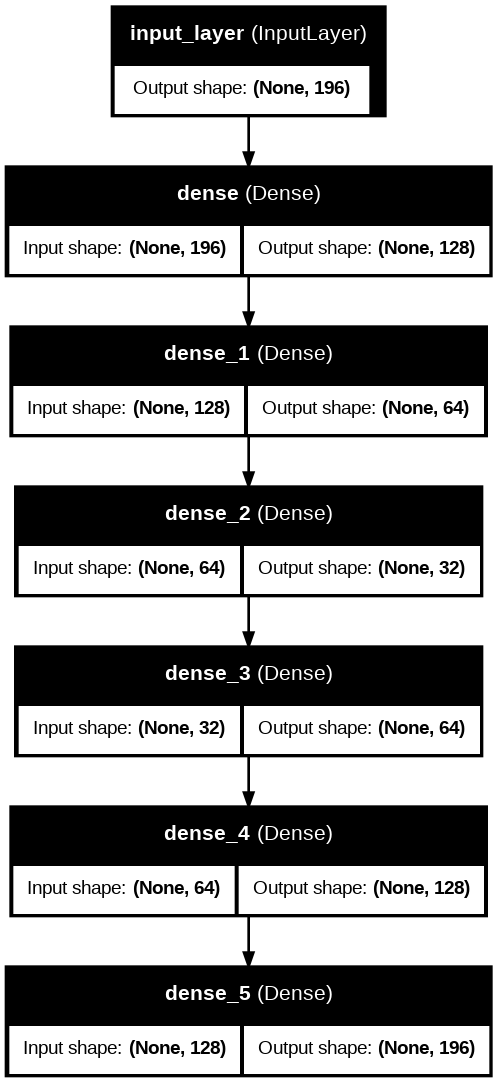

In [58]:
visualize_model(autoencoder, show_shapes=True)

# Training phase


In [59]:
history = train_autoencoder_with_validation(autoencoder, X_train, X_test, batch_size=32, epochs=300, patience = 15)

Epoch 1/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1851 - val_loss: 0.1156
Epoch 2/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1001 - val_loss: 0.0673
Epoch 3/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0639 - val_loss: 0.0569
Epoch 4/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0557 - val_loss: 0.0531
Epoch 5/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0523 - val_loss: 0.0501
Epoch 6/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0508 - val_loss: 0.0476
Epoch 7/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0488 - val_loss: 0.0453
Epoch 8/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0456 - val_loss: 0.0432
Epoch 9/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0420 - val_loss: 0.0413
Epoch 10/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0413 - val_loss: 0.0393
Epoch 11/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0396 - val_loss: 0.0378
Epoch 12/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

We now visualize the loss history during the training phase

In [60]:
def plot_training_history(history):
    """
    Plots training and validation loss curves.

    Args:
        history: Keras History object returned by model.fit()
    """
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print final validation loss
    final_val_loss = history.history['val_loss'][-1]
    print(f"Final Validation Loss: {final_val_loss:.4f}")

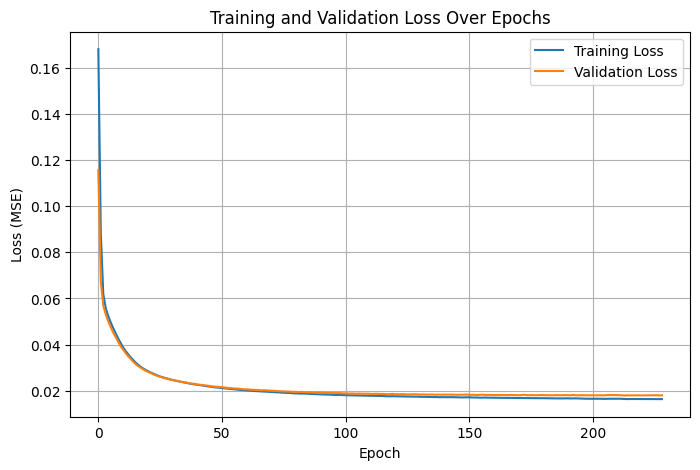

Final Validation Loss: 0.0180


In [61]:
plot_training_history(history)

# Prepare dataset for clustering
Now that we have trained our autoencoder, we use only the encoder part to map each feature vector to a latent space. Then we will use this dataset to run our clustering algorithm.

In [62]:
m_cluster_dataset, m_le, m_id_to_name = encode_player_names(m_complete)
w_cluster_dataset, w_le, w_id_to_name = encode_player_names(w_complete)

# Normalization
m_df = normalize_tennis_data_minmax(m_cluster_dataset, exclude_cols=['player'])
w_df = normalize_tennis_data_minmax(w_cluster_dataset, exclude_cols=['player'])

mixed_df = pd.concat([m_df, w_df], ignore_index=True)
mixed_dict = {**m_id_to_name, **w_id_to_name}


=== Encoding Player Names ===
Original dataset: 82 players
Unique players in dataset: 82
Encoded dataset: 82 players
LabelEncoder fitted on 82 unique players

=== Encoding Player Names ===
Original dataset: 33 players
Unique players in dataset: 33
Encoded dataset: 33 players
LabelEncoder fitted on 33 unique players


In [63]:
def encode_dataset_to_latent_space(encoder_model, df_scaled, scaler=None):
    player_ids = df_scaled['player'].reset_index(drop=True)
    features_scaled = df_scaled.drop(columns=['player'])
    latent_space = encoder_model.predict(features_scaled, verbose=0)
    latent_cols = [f'latent_{i+1}' for i in range(latent_space.shape[1])]
    latent_df = pd.DataFrame(latent_space, columns=latent_cols)
    if scaler is None:
        scaler = StandardScaler()
        latent_df[latent_cols] = scaler.fit_transform(latent_df[latent_cols])
    else:
        latent_df[latent_cols] = scaler.transform(latent_df[latent_cols])
    latent_df['player'] = player_ids
    return latent_df, scaler


In [64]:
def plot_latent_space(latent_df, player_names_map, dataset_name="Dataset"):
    """
    plots the latent space using plot_pca_3d if needed.

    Args:
        latent_df: dataset to plot.
        player_names_map: Dictionary mapping player IDs back to names.
        dataset_name: Name of the dataset for plot title.
    """
    print(f"\n=== Encoding and Plotting Latent Space for {dataset_name} ===")



    if latent_df.shape[1] - 1 == 3: # Check if latent space is 3D
      # Rename latent columns for consistent plotting function input
      latent_df_renamed = latent_df.rename(columns={
          'latent_1': 'PC1',
          'latent_2': 'PC2',
          'latent_3': 'PC3'
          })
      # Now plot using Plotly directly from the latent space DataFrame
      fig = px.scatter_3d(latent_df_renamed, x='PC1', y='PC2', z='PC3',
                        hover_name=latent_df_renamed['player'].map(player_names_map), # Map player IDs back to names for hover
                        title=f'{dataset_name} Player Style Clustering (Latent Space 3D)',
                        labels={'PC1': 'Latent Dimension 1',
                                'PC2': 'Latent Dimension 2',
                                'PC3': 'Latent Dimension 3'})

      fig.update_layout(
          margin=dict(l=0, r=0, b=0, t=40),
          hovermode='closest'
      )

      fig.show()

    else:
      print(f"Latent space dimension is {latent_df.shape[1]}. 3D plotting requires 3 dimensions.")
      plot_pca_3d(latent_df, player_names_map, dataset_name)

We now want to focus only on players with complete data.

In [111]:
# Encode and plot the latent space for men's dataset
m_latent_df, m_latent_scaler = encode_dataset_to_latent_space(encoder, m_df)
plot_latent_space(m_latent_df, m_id_to_name, "Men's Dataset (Latent Space)")

w_latent_df, w_latent_scaler = encode_dataset_to_latent_space(encoder, w_df)
plot_latent_space(w_latent_df, w_id_to_name, "Women's Dataset (Latent Space)")



=== Encoding and Plotting Latent Space for Men's Dataset (Latent Space) ===
Latent space dimension is 33. 3D plotting requires 3 dimensions.

=== Performing PCA and Plotting for Men's Dataset (Latent Space) ===


Explained variance ratio by each component: [0.3160812  0.233454   0.12836948]
Total explained variance ratio: 0.6779047250747681

=== Encoding and Plotting Latent Space for Women's Dataset (Latent Space) ===
Latent space dimension is 33. 3D plotting requires 3 dimensions.

=== Performing PCA and Plotting for Women's Dataset (Latent Space) ===


Explained variance ratio by each component: [0.36049053 0.20312709 0.13804999]
Total explained variance ratio: 0.7016675472259521


# Cluster phase

In [66]:
def cluster_with_metrics(latent_df, k_range=range(2, 50), random_state=42):
    """
    Cluster latent space features with K-means and evaluate using multiple metrics.

    Args:
        latent_df: DataFrame with latent space features (numeric columns only)
        k_range: range of k values to test
        random_state: random seed for reproducibility

    Returns:
        metrics_df: DataFrame with scores for each k
    """
    X = latent_df.values  # ensure it's numeric
    silhouette_scores = []
    dbi_scores = []
    ch_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X)

        silhouette_scores.append(silhouette_score(X, labels))
        dbi_scores.append(davies_bouldin_score(X, labels))
        ch_scores.append(calinski_harabasz_score(X, labels))

    # Store metrics
    metrics_df = pd.DataFrame({
        'k': list(k_range),
        'Silhouette': silhouette_scores,
        'Davies-Bouldin': dbi_scores,
        'Calinski-Harabasz': ch_scores
    })

    # Plot metrics
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].plot(metrics_df['k'], metrics_df['Silhouette'], marker='o')
    axs[0].set_title('Silhouette (Higher Better)')
    axs[0].set_xlabel('Number of Clusters (k)')
    axs[0].set_ylabel('Score')

    axs[1].plot(metrics_df['k'], metrics_df['Davies-Bouldin'], marker='o', color='orange')
    axs[1].set_title('Davies-Bouldin (Lower Better)')
    axs[1].set_xlabel('Number of Clusters (k)')
    axs[1].set_ylabel('Score')

    axs[2].plot(metrics_df['k'], metrics_df['Calinski-Harabasz'], marker='o', color='green')
    axs[2].set_title('Calinski-Harabasz (Higher Better)')
    axs[2].set_xlabel('Number of Clusters (k)')
    axs[2].set_ylabel('Score')

    plt.tight_layout()
    plt.show()

    return metrics_df


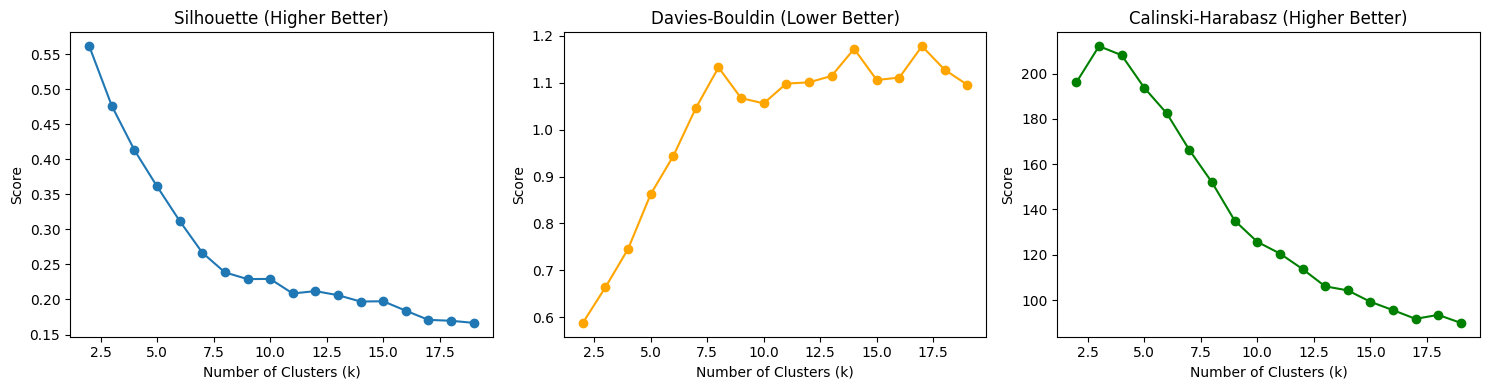

,k,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,2,0.561702,0.587735,196.177912
1,3,0.476271,0.663763,212.131144
2,4,0.413146,0.745355,208.152762
3,5,0.361427,0.862138,193.765478
4,6,0.312144,0.943679,182.400756
5,7,0.266854,1.046247,166.211764
6,8,0.238710,1.132830,151.923784
7,9,0.229119,1.067416,135.081017
8,10,0.229369,1.056133,125.704054
9,11,0.208572,1.098383,120.545106


In [67]:
cluster_with_metrics(m_latent_df, k_range=range(2,20))

In [114]:
def visualize_clustering(
    latent_df,
    k_list,
    player_names_map=None,
    player_col='player',
    reducer='umap',  # 'pca', 'tsne', or 'umap'
    random_state=42,
    dataset_name="Dataset"
):
    """
    For each k in k_list, runs KMeans on latent_df and visualizes the clusters
    in interactive 3D plot after dimensionality reduction using PCA, t-SNE, or UMAP.

    Args:
        latent_df (pd.DataFrame): Latent features with optional player column.
        k_list (list[int]): List of cluster counts to try.
        player_names_map (dict): Dictionary mapping player IDs back to names (optional).
        player_col (str): Column containing player IDs/names in latent_df.
        reducer (str): Dimensionality reduction method ('pca', 'tsne', or 'umap').
        random_state (int): Random seed for reproducibility.
        dataset_name (str): Name of the dataset for plot titles.

    Returns:
        None
    """
    print(f"\n=== Visualizing KMeans clusters for {dataset_name} using {reducer.upper()} (3D Interactive) ===")

    # Separate features and players
    if player_col in latent_df.columns:
        players = latent_df[player_col]
        features = latent_df.drop(columns=[player_col])
    else:
        players = None
        features = latent_df

    # Dimensionality reduction to 3D
    if reducer == 'pca':
        reducer_model = PCA(n_components=3, random_state=random_state)
        reduced_features = reducer_model.fit_transform(features)
    elif reducer == 'tsne':
        reducer_model = TSNE(n_components=3, random_state=random_state, perplexity=30, n_iter=300)
        reduced_features = reducer_model.fit_transform(features)
    elif reducer == 'umap':
        reducer_model = umap.UMAP(n_components=3, random_state=random_state, n_neighbors=15, min_dist=0.1)
        reduced_features = reducer_model.fit_transform(features)
    else:
        raise ValueError("Reducer must be 'pca', 'tsne', or 'umap'.")

    # Prepare DataFrame for plotly
    plot_df = pd.DataFrame({
        'Dim1': reduced_features[:, 0],
        'Dim2': reduced_features[:, 1],
        'Dim3': reduced_features[:, 2],
    })

    if players is not None:
        plot_df[player_col] = players
        if player_names_map is not None:
            plot_df['player_name'] = plot_df[player_col].map(player_names_map)
        else:
            plot_df['player_name'] = plot_df[player_col].astype(str)
    else:
        plot_df['player_name'] = "Unknown"

    for k in k_list:
        print(f"\n--- KMeans clustering with k={k} ---")
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        print(f'clustering on {features.shape} shape df' )
        cluster_labels = kmeans.fit_predict(features)
        plot_df['cluster'] = cluster_labels.astype(str)  # convert to str for categorical coloring

        fig = px.scatter_3d(
            plot_df,
            x='Dim1', y='Dim2', z='Dim3',
            color='cluster',
            hover_name='player_name',
            title=f"KMeans Clusters (k={k}) using {reducer.upper()} for {dataset_name}",
            color_discrete_sequence=px.colors.qualitative.Safe,
            opacity=0.8,
            width=1200,
            height=600
        )

        fig.update_layout(
            legend_title_text='Cluster',
            margin=dict(l=0, r=0, b=0, t=40)
        )

        fig.show()

        # Print cluster stats
        unique_labels, counts = np.unique(cluster_labels, return_counts=True)
        print("Cluster counts:")
        for label, count in zip(unique_labels, counts):
            print(f"Cluster {label}: {count}")

        if players is not None and player_names_map is not None:
            print("Players per cluster:")
            for c in unique_labels:
                sample_players_ids = players[cluster_labels == c].tolist()
                sample_players_names = [player_names_map.get(pid, f"ID_{pid}") for pid in sample_players_ids]
                print(f"Cluster {c}: {sample_players_names}")


In [115]:
k_values = [2, 6, 7, 8, 9, 10, 11 , 12]
visualize_clustering(
    latent_df=m_latent_df,
    k_list=k_values,
    player_names_map=m_id_to_name,
    player_col='player',
    reducer='umap',
    random_state=42,
    dataset_name="Tennis Players"
)


=== Visualizing KMeans clusters for Tennis Players using UMAP (3D Interactive) ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




--- KMeans clustering with k=2 ---
clustering on (82, 32) shape df


Cluster counts:
Cluster 0: 63
Cluster 1: 19
Players per cluster:
Cluster 0: ['Jannik Sinner', 'Carlos Alcaraz', 'Novak Djokovic', 'Alexander Zverev', 'Andrey Rublev', 'Holger Rune', 'Lorenzo Musetti', 'Tallon Griekspoor', 'Alexander Bublik', 'Alex De Minaur', 'Hubert Hurkacz', 'Taylor Fritz', 'Tommy Paul', 'Casper Ruud', 'Stefanos Tsitsipas', 'Ben Shelton', 'Miomir Kecmanovic', 'Stan Wawrinka', 'Borna Coric', 'Daniil Medvedev', 'Sebastian Korda', 'Alexei Popyrin', 'Roberto Bautista Agut', 'Frances Tiafoe', 'Marin Cilic', 'Grigor Dimitrov', 'Gael Monfils', 'Botic Van De Zandschulp', 'Denis Shapovalov', 'Nick Kyrgios', 'Lorenzo Sonego', 'David Goffin', 'Matteo Berrettini', 'Diego Schwartzman', 'Kei Nishikori', 'Felix Auger Aliassime', 'Richard Gasquet', 'Adrian Mannarino', 'Karen Khachanov', 'Dominic Thiem', 'Lucas Pouille', 'Daniel Evans', 'Emil Ruusuvuori', 'Robin Haase', 'Marton Fucsovics', 'Dusan Lajovic', 'Fabio Fognini', 'Andy Murray', 'Milos Raonic', 'John Isner', 'Gilles Simon', 

Cluster counts:
Cluster 0: 10
Cluster 1: 14
Cluster 2: 13
Cluster 3: 21
Cluster 4: 6
Cluster 5: 18
Players per cluster:
Cluster 0: ['Carlos Alcaraz', 'Holger Rune', 'Alexander Bublik', 'Ben Shelton', 'Alexei Popyrin', 'Frances Tiafoe', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Fabio Fognini', 'Benoit Paire']
Cluster 1: ['Rafael Nadal', 'Roger Federer', 'Tommy Haas', 'Lleyton Hewitt', 'Andy Roddick', 'Thomas Muster', 'Fernando Gonzalez', 'Carlos Moya', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Jim Courier', 'Michael Chang']
Cluster 2: ['Andrey Rublev', 'Tallon Griekspoor', 'Sebastian Korda', 'Marin Cilic', 'Denis Shapovalov', 'Nick Kyrgios', 'Matteo Berrettini', 'Felix Auger Aliassime', 'Lucas Pouille', 'Milos Raonic', 'John Isner', 'Jo Wilfried Tsonga', 'Kevin Anderson']
Cluster 3: ['Jannik Sinner', 'Novak Djokovic', 'Alexander Zverev', 'Hubert Hurkacz', 'Taylor Fritz', 'Borna Coric', 'Daniil Medvedev', 'Gael Monfils', 'David Goffin', 'Diego Schwartz

Cluster counts:
Cluster 0: 10
Cluster 1: 13
Cluster 2: 16
Cluster 3: 17
Cluster 4: 6
Cluster 5: 18
Cluster 6: 2
Players per cluster:
Cluster 0: ['Carlos Alcaraz', 'Holger Rune', 'Alexander Bublik', 'Ben Shelton', 'Alexei Popyrin', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Matteo Berrettini', 'Fabio Fognini', 'Benoit Paire']
Cluster 1: ['Roger Federer', 'Tommy Haas', 'Lleyton Hewitt', 'Andy Roddick', 'Thomas Muster', 'Fernando Gonzalez', 'Carlos Moya', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Jim Courier', 'Michael Chang']
Cluster 2: ['Alexander Zverev', 'Andrey Rublev', 'Tallon Griekspoor', 'Hubert Hurkacz', 'Taylor Fritz', 'Borna Coric', 'Sebastian Korda', 'Frances Tiafoe', 'Marin Cilic', 'Denis Shapovalov', 'Nick Kyrgios', 'Felix Auger Aliassime', 'Lucas Pouille', 'Jo Wilfried Tsonga', 'Kevin Anderson', 'Tomas Berdych']
Cluster 3: ['Jannik Sinner', 'Novak Djokovic', 'Daniil Medvedev', 'Gael Monfils', 'David Goffin', 'Diego Schwartzman', 'Kei Nishi

Cluster counts:
Cluster 0: 14
Cluster 1: 10
Cluster 2: 4
Cluster 3: 14
Cluster 4: 23
Cluster 5: 1
Cluster 6: 12
Cluster 7: 4
Players per cluster:
Cluster 0: ['Holger Rune', 'Lorenzo Musetti', 'Casper Ruud', 'Stefanos Tsitsipas', 'Ben Shelton', 'Stan Wawrinka', 'Grigor Dimitrov', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Dominic Thiem', 'Daniel Evans', 'Robin Haase', 'Marton Fucsovics', 'Dusan Lajovic']
Cluster 1: ['Roger Federer', 'Tommy Haas', 'Lleyton Hewitt', 'Andy Roddick', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Michael Chang', 'Jimmy Connors']
Cluster 2: ['Stefan Edberg', 'Pete Sampras', 'Ivan Lendl', 'John Mcenroe']
Cluster 3: ['Novak Djokovic', 'Alex De Minaur', 'Miomir Kecmanovic', 'Daniil Medvedev', 'Roberto Bautista Agut', 'Diego Schwartzman', 'Richard Gasquet', 'Rafael Nadal', 'Andy Murray', 'Gilles Simon', 'Juan Martin Del Potro', 'David Ferrer', 'Mikhail Youzhny', 'Nikolay Davydenko']
Cluster 4: ['Jannik Sinner', 'Carlos Alcaraz', 'Al

Cluster counts:
Cluster 0: 10
Cluster 1: 8
Cluster 2: 4
Cluster 3: 11
Cluster 4: 21
Cluster 5: 1
Cluster 6: 7
Cluster 7: 3
Cluster 8: 17
Players per cluster:
Cluster 0: ['Carlos Alcaraz', 'Holger Rune', 'Alexander Bublik', 'Ben Shelton', 'Alexei Popyrin', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Matteo Berrettini', 'Fabio Fognini', 'Benoit Paire']
Cluster 1: ['Lleyton Hewitt', 'Andy Roddick', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Michael Chang', 'Jimmy Connors']
Cluster 2: ['Stefan Edberg', 'Pete Sampras', 'Ivan Lendl', 'John Mcenroe']
Cluster 3: ['Novak Djokovic', 'Alex De Minaur', 'Miomir Kecmanovic', 'Daniil Medvedev', 'Roberto Bautista Agut', 'Diego Schwartzman', 'Rafael Nadal', 'Andy Murray', 'Gilles Simon', 'David Ferrer', 'Nikolay Davydenko']
Cluster 4: ['Jannik Sinner', 'Alexander Zverev', 'Andrey Rublev', 'Hubert Hurkacz', 'Taylor Fritz', 'Tommy Paul', 'Borna Coric', 'Sebastian Korda', 'Frances Tiafoe', 'Marin Cilic', 'Gael Monfils', 'D

Cluster counts:
Cluster 0: 10
Cluster 1: 7
Cluster 2: 2
Cluster 3: 11
Cluster 4: 21
Cluster 5: 1
Cluster 6: 7
Cluster 7: 3
Cluster 8: 17
Cluster 9: 3
Players per cluster:
Cluster 0: ['Carlos Alcaraz', 'Holger Rune', 'Alexander Bublik', 'Ben Shelton', 'Alexei Popyrin', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Matteo Berrettini', 'Fabio Fognini', 'Benoit Paire']
Cluster 1: ['Lleyton Hewitt', 'Andy Roddick', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Michael Chang']
Cluster 2: ['Pete Sampras', 'Ivan Lendl']
Cluster 3: ['Novak Djokovic', 'Alex De Minaur', 'Miomir Kecmanovic', 'Daniil Medvedev', 'Roberto Bautista Agut', 'Diego Schwartzman', 'Rafael Nadal', 'Andy Murray', 'Gilles Simon', 'David Ferrer', 'Nikolay Davydenko']
Cluster 4: ['Jannik Sinner', 'Alexander Zverev', 'Andrey Rublev', 'Hubert Hurkacz', 'Taylor Fritz', 'Tommy Paul', 'Borna Coric', 'Sebastian Korda', 'Frances Tiafoe', 'Marin Cilic', 'Gael Monfils', 'David Goffin', 'Kei Nishikori', 'Felix

Cluster counts:
Cluster 0: 12
Cluster 1: 7
Cluster 2: 2
Cluster 3: 8
Cluster 4: 21
Cluster 5: 1
Cluster 6: 4
Cluster 7: 3
Cluster 8: 15
Cluster 9: 3
Cluster 10: 6
Players per cluster:
Cluster 0: ['Carlos Alcaraz', 'Holger Rune', 'Tallon Griekspoor', 'Alexander Bublik', 'Ben Shelton', 'Alexei Popyrin', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Matteo Berrettini', 'Lucas Pouille', 'Fabio Fognini', 'Benoit Paire']
Cluster 1: ['Lleyton Hewitt', 'Andy Roddick', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Michael Chang']
Cluster 2: ['Pete Sampras', 'Ivan Lendl']
Cluster 3: ['Novak Djokovic', 'Daniil Medvedev', 'Richard Gasquet', 'Rafael Nadal', 'Andy Murray', 'Gilles Simon', 'Juan Martin Del Potro', 'Nikolay Davydenko']
Cluster 4: ['Jannik Sinner', 'Alexander Zverev', 'Andrey Rublev', 'Hubert Hurkacz', 'Taylor Fritz', 'Tommy Paul', 'Borna Coric', 'Sebastian Korda', 'Frances Tiafoe', 'Marin Cilic', 'Gael Monfils', 'David Goffin', 'Kei Nishikori', 'Felix Auger

Cluster counts:
Cluster 0: 9
Cluster 1: 7
Cluster 2: 2
Cluster 3: 8
Cluster 4: 18
Cluster 5: 1
Cluster 6: 9
Cluster 7: 3
Cluster 8: 11
Cluster 9: 2
Cluster 10: 5
Cluster 11: 7
Players per cluster:
Cluster 0: ['Carlos Alcaraz', 'Holger Rune', 'Alexander Bublik', 'Ben Shelton', 'Alexei Popyrin', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Fabio Fognini', 'Benoit Paire']
Cluster 1: ['Roger Federer', 'Philipp Kohlschreiber', 'Tomas Berdych', 'Mikhail Youzhny', 'Tommy Haas', 'Andy Roddick', 'Marat Safin']
Cluster 2: ['Pete Sampras', 'Ivan Lendl']
Cluster 3: ['Novak Djokovic', 'Daniil Medvedev', 'Richard Gasquet', 'Rafael Nadal', 'Andy Murray', 'Gilles Simon', 'Juan Martin Del Potro', 'Nikolay Davydenko']
Cluster 4: ['Jannik Sinner', 'Alexander Zverev', 'Andrey Rublev', 'Hubert Hurkacz', 'Taylor Fritz', 'Tommy Paul', 'Borna Coric', 'Sebastian Korda', 'Frances Tiafoe', 'Marin Cilic', 'Gael Monfils', 'David Goffin', 'Kei Nishikori', 'Adrian Mannarino', 'Karen Khachanov', 'Emil Ruusuvuori', '

We now try wth other clustering methods

In [70]:
def visualize_cluster_regions(model, features_df, id_to_player, plot_3d=True, random_state=42):
    """
    Visualizes cluster regions for any fitted clustering model using convex hulls.

    Args:
        model: Fitted clustering model (GMM, KMeans, etc.)
        features_df (pd.DataFrame): DataFrame with features
        id_to_player (dict): Mapping from player ID to player name
        plot_3d (bool): Whether to plot in 3D (True) or 2D (False)
        random_state (int): Random seed for UMAP

    Returns:
        plotly.graph_objects.Figure: Interactive plot showing cluster regions
    """
    if 'player' in features_df.columns:
        player_ids = features_df['player'].values
        X_features = features_df.drop(columns=['player'])
        X = X_features.values
    else:
        player_ids = features_df.index.values
        X_features = features_df
        X = features_df.values

    if hasattr(model, 'predict'):
        clusters = model.predict(X_features)
    elif hasattr(model, 'fit_predict'):
        clusters = model.fit_predict(X_features)
    elif hasattr(model, 'labels_'):
        clusters = model.labels_
    else:
        raise ValueError("Model must have 'predict', 'fit_predict', or 'labels_' attribute")

    n_components = len(np.unique(clusters))

    if plot_3d:
        reducer = umap.UMAP(n_components=3, random_state=random_state)
    else:
        reducer = umap.UMAP(n_components=2, random_state=random_state)

    embedding = reducer.fit_transform(X)

    if plot_3d:
        cols = ['x', 'y', 'z']
    else:
        cols = ['x', 'y']

    plot_df = pd.DataFrame(embedding, columns=cols)
    plot_df['Cluster'] = clusters
    plot_df['Player'] = [id_to_player.get(pid, "Unknown") for pid in player_ids]

    fig = go.Figure()
    colors = px.colors.qualitative.Set3[:n_components]

    for cluster_id in range(n_components):
        cluster_mask = plot_df['Cluster'] == cluster_id
        cluster_data = plot_df[cluster_mask]

        if len(cluster_data) > 0:
            if plot_3d and len(cluster_data) >= 4:
                try:
                    hull = ConvexHull(cluster_data[['x', 'y', 'z']].values)
                    vertices = cluster_data[['x', 'y', 'z']].values[hull.vertices]

                    fig.add_trace(go.Mesh3d(
                        x=vertices[:, 0],
                        y=vertices[:, 1],
                        z=vertices[:, 2],
                        color=colors[cluster_id],
                        opacity=0.3,
                        name=f'Cluster {cluster_id} Boundary',
                        showlegend=True
                    ))
                except:
                    pass
            elif not plot_3d and len(cluster_data) >= 3:
                try:
                    hull = ConvexHull(cluster_data[['x', 'y']].values)
                    vertices = cluster_data[['x', 'y']].values[hull.vertices]

                    fig.add_trace(go.Scatter(
                        x=np.append(vertices[:, 0], vertices[0, 0]),
                        y=np.append(vertices[:, 1], vertices[0, 1]),
                        mode='lines',
                        line=dict(color=colors[cluster_id], width=2),
                        fill='toself',
                        fillcolor=colors[cluster_id],
                        opacity=0.3,
                        name=f'Cluster {cluster_id} Boundary',
                        showlegend=True
                    ))
                except:
                    pass

            if plot_3d:
                fig.add_trace(go.Scatter3d(
                    x=cluster_data['x'],
                    y=cluster_data['y'],
                    z=cluster_data['z'],
                    mode='markers',
                    marker=dict(
                        size=8,
                        color=colors[cluster_id],
                        opacity=0.8,
                        symbol='circle'
                    ),
                    name=f'Cluster {cluster_id} Points',
                    showlegend=False,
                    customdata=cluster_data[['Player', 'Cluster']].values,
                    hovertemplate='<b>%{customdata[0]}</b><br>' +
                                'Cluster: %{customdata[1]}<br>' +
                                'X: %{x:.2f}<br>' +
                                'Y: %{y:.2f}<br>' +
                                'Z: %{z:.2f}<extra></extra>'
                ))
            else:
                fig.add_trace(go.Scatter(
                    x=cluster_data['x'],
                    y=cluster_data['y'],
                    mode='markers',
                    marker=dict(
                        size=10,
                        color=colors[cluster_id],
                        opacity=0.8,
                        symbol='circle'
                    ),
                    name=f'Cluster {cluster_id} Points',
                    showlegend=False,
                    customdata=cluster_data[['Player', 'Cluster']].values,
                    hovertemplate='<b>%{customdata[0]}</b><br>' +
                                'Cluster: %{customdata[1]}<br>' +
                                'X: %{x:.2f}<br>' +
                                'Y: %{y:.2f}<extra></extra>'
                ))

    if plot_3d:
        fig.update_layout(
            title=f'Cluster Regions Visualization (k={n_components})',
            scene=dict(
                xaxis_title='UMAP-1',
                yaxis_title='UMAP-2',
                zaxis_title='UMAP-3',
                camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
            ),
            width=1000,
            height=800
        )
    else:
        fig.update_layout(
            title=f'Cluster Regions Visualization (k={n_components})',
            xaxis_title='UMAP-1',
            yaxis_title='UMAP-2',
            width=1000,
            height=800
        )

    return fig

In [71]:

def cluster_with_models(latent_df, mapper, k, random_state=42):
  # Example with GMM
  gmm = GaussianMixture(n_components=k, random_state=42)
  gmm.fit(latent_df.drop(columns='player'))
  fig_gmm = visualize_cluster_regions(gmm, latent_df, mapper, plot_3d=True)
  fig_gmm.show()

  # Example with KMeans
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(latent_df.drop(columns='player'))
  fig_kmeans = visualize_cluster_regions(kmeans, latent_df, mapper, plot_3d=True)
  fig_kmeans.show()

In [117]:
cluster_with_models(m_latent_df, m_id_to_name, 6)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [118]:
cluster_with_models(m_latent_df, m_id_to_name, 3)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# More testing
We now will run two experiment:
- Train the encoder only on the means
- Train the encoder only on the stds

In this way we expect the styles to change, since in the first case we will only consider the playing style without taking count of the consistency. In the second case we will only focus on consistency, thus we will cluster players based on the playing consistency.

In [74]:
m_means_df = m_dataset_scaled.loc[:, ~m_dataset_scaled.columns.str.contains('_std')]
w_means_df = w_dataset_scaled.loc[:, ~w_dataset_scaled.columns.str.contains('_std')]
mixed_means_df = pd.concat([m_means_df, w_means_df])

## Split train and test

In [75]:
X_means_train, X_means_test = train_test_split(mixed_means_df.drop(columns=['player']), test_size=0.2, random_state=42)

In [76]:
X_means_train.shape

(317, 98)

In [77]:
X_means_train.head()

,first_serve_aces_pct_mean,first_serve_unret_pct_mean,first_serve_forced_err_pct_mean,first_serve_wide_pct_mean,first_serve_body_pct_mean,first_serve_t_pct_mean,second_serve_aces_pct_mean,second_serve_unret_pct_mean,second_serve_forced_err_pct_mean,second_serve_wide_pct_mean,...,fh_err_wide_pct_mean,fh_err_wide_deep_pct_mean,bh_shallow_pct_mean,bh_deep_pct_mean,bh_very_deep_pct_mean,bh_unforced_pct_mean,bh_err_net_pct_mean,bh_err_deep_pct_mean,bh_err_wide_pct_mean,bh_err_wide_deep_pct_mean
36,0.267795,0.235902,0.625013,0.519773,0.305970,0.594813,0.091592,0.000000,0.562911,0.178598,...,0.275268,0.204211,0.185472,0.539691,0.771277,0.200681,0.165767,0.422005,0.368382,0.049123
113,0.709698,0.597846,0.373864,0.879004,0.145214,0.324594,1.000000,0.691928,0.765890,0.840801,...,0.365988,0.436782,0.151690,0.565695,0.764157,0.843322,0.920593,0.387543,0.278208,0.000000
176,0.217383,0.067855,0.522413,0.374888,0.407731,0.564200,0.030349,0.021099,0.280473,0.546568,...,0.525586,0.121921,0.246682,0.734889,0.447896,0.346440,0.399485,0.507466,0.355639,0.135849
63,0.460373,0.263011,0.688524,0.517515,0.182266,0.647168,0.108327,0.046542,0.559667,0.349778,...,0.300574,0.204244,0.130488,0.498141,0.866254,0.681865,0.562541,0.378096,0.574899,0.162554
19,0.484269,0.338066,0.727234,0.648069,0.426958,0.354461,0.139308,0.143952,0.578405,0.288603,...,0.179370,0.263441,0.475540,0.377882,0.578068,0.184802,0.422222,0.206810,0.273642,0.075269


In [78]:
means_autoencoder, means_encoder = build_autoencoder(input_dim=X_means_train.shape[1], latent_dim=32, denoising=False)

In [79]:
history = train_autoencoder_with_validation(means_autoencoder, X_means_train, X_means_test, batch_size=32, epochs=300, patience = 15)

Epoch 1/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1713 - val_loss: 0.0981
Epoch 2/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0853 - val_loss: 0.0589
Epoch 3/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0560 - val_loss: 0.0539
Epoch 4/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0536 - val_loss: 0.0503
Epoch 5/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0493 - val_loss: 0.0474
Epoch 6/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0467 - val_loss: 0.0452
Epoch 7/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0452 - val_loss: 0.0433
Epoch 8/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0429 - val_loss: 0.0414
Epoch 9/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0399 - val_loss: 0.0397
Epoch 10/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0393 - val_loss: 0.0383
Epoch 11/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0373 - val_loss: 0.0367
Epoch 12/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

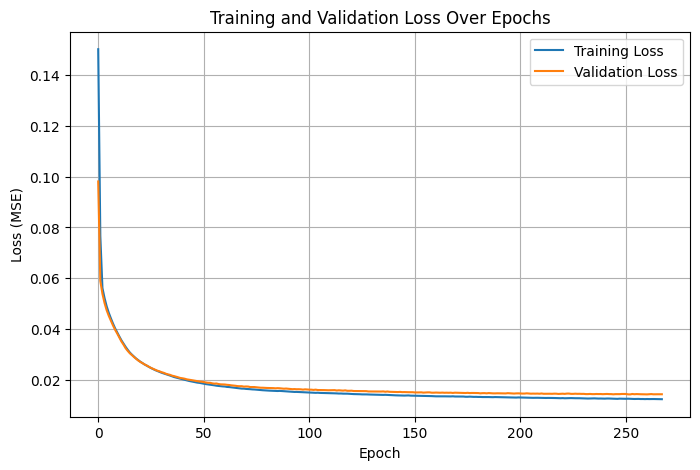

Final Validation Loss: 0.0144


In [80]:
plot_training_history(history)

In [81]:
# Normalization


m_means_df = normalize_tennis_data_minmax(m_cluster_dataset.loc[:, ~m_cluster_dataset.columns.str.contains('_std')], exclude_cols=['player'])
w_means_df = normalize_tennis_data_minmax(w_cluster_dataset.loc[:, ~w_cluster_dataset.columns.str.contains('_std')], exclude_cols=['player'])

mixed_means_df = pd.concat([m_df, w_df], ignore_index=True)
mixed_dict = {**m_id_to_name, **w_id_to_name}


In [82]:
# Encode and plot the latent space for men's dataset
m_means_latent_df, m_means_latent_scaler = encode_dataset_to_latent_space(means_encoder, m_means_df)
plot_latent_space(m_means_latent_df, m_id_to_name, "Men's Dataset (Latent Space)")

w_means_latent_df, w_means_latent_scaler = encode_dataset_to_latent_space(means_encoder, w_means_df)
plot_latent_space(w_means_latent_df, w_id_to_name, "Women's Dataset (Latent Space)")



=== Encoding and Plotting Latent Space for Men's Dataset (Latent Space) ===
Latent space dimension is 33. 3D plotting requires 3 dimensions.

=== Performing PCA and Plotting for Men's Dataset (Latent Space) ===


Explained variance ratio by each component: [0.2607303  0.20166239 0.09723232]
Total explained variance ratio: 0.5596250295639038

=== Encoding and Plotting Latent Space for Women's Dataset (Latent Space) ===
Latent space dimension is 33. 3D plotting requires 3 dimensions.

=== Performing PCA and Plotting for Women's Dataset (Latent Space) ===


Explained variance ratio by each component: [0.24766482 0.20063153 0.11519921]
Total explained variance ratio: 0.5634955763816833


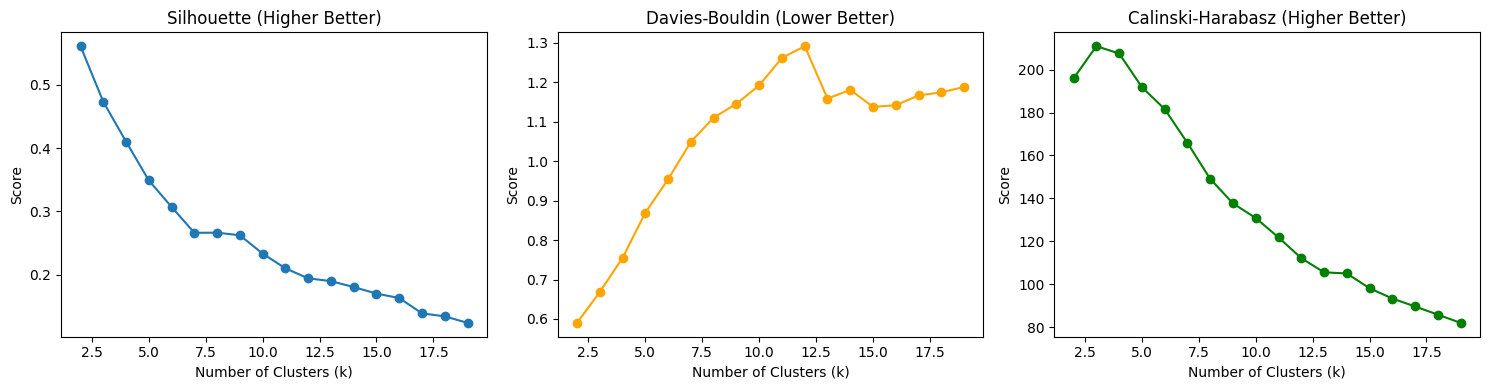

,k,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,2,0.560392,0.590086,195.912758
1,3,0.472867,0.668506,210.934085
2,4,0.410067,0.754965,207.519408
3,5,0.348942,0.869624,191.856821
4,6,0.307223,0.954197,181.614546
5,7,0.266419,1.049261,165.849949
6,8,0.266646,1.110472,149.082433
7,9,0.262557,1.145621,137.640197
8,10,0.233646,1.192315,130.834528
9,11,0.210487,1.261995,121.779527


In [83]:
cluster_with_metrics(m_means_latent_df, k_range=range(2,20))

In [84]:
k_values = [6, 7, 8, 9, 10, 12]
visualize_clustering(
    latent_df=m_means_latent_df,
    k_list=k_values,
    player_names_map=m_id_to_name,
    player_col='player',
    reducer='pca',
    random_state=42,
    dataset_name="Tennis Players"
)


=== Visualizing KMeans clusters for Tennis Players using PCA (3D Interactive) ===

--- KMeans clustering with k=6 ---
clustering on (82, 32) shape df


Cluster counts:
Cluster 0: 20
Cluster 1: 15
Cluster 2: 13
Cluster 3: 5
Cluster 4: 10
Cluster 5: 19
\Players per cluster:
Cluster 0: ['Holger Rune', 'Tallon Griekspoor', 'Alexander Bublik', 'Hubert Hurkacz', 'Casper Ruud', 'Ben Shelton', 'Borna Coric', 'Alexei Popyrin', 'Marin Cilic', 'Botic Van De Zandschulp', 'Denis Shapovalov', 'Nick Kyrgios', 'Lorenzo Sonego', 'Matteo Berrettini', 'Felix Auger Aliassime', 'Lucas Pouille', 'Fabio Fognini', 'Milos Raonic', 'John Isner', 'Benoit Paire']
Cluster 1: ['Jannik Sinner', 'Carlos Alcaraz', 'Alex De Minaur', 'Tommy Paul', 'David Goffin', 'Diego Schwartzman', 'Kei Nishikori', 'Rafael Nadal', 'Emil Ruusuvuori', 'Fernando Verdasco', 'Juan Martin Del Potro', 'Philipp Kohlschreiber', 'David Ferrer', 'Tomas Berdych', 'Nikolay Davydenko']
Cluster 2: ['Lorenzo Musetti', 'Stan Wawrinka', 'Grigor Dimitrov', 'Dominic Thiem', 'Daniel Evans', 'Robin Haase', 'Marton Fucsovics', 'Dusan Lajovic', 'Jo Wilfried Tsonga', 'Roger Federer', 'Mikhail Youzhny', 'Tomm

Cluster counts:
Cluster 0: 11
Cluster 1: 15
Cluster 2: 7
Cluster 3: 5
Cluster 4: 10
Cluster 5: 14
Cluster 6: 20
\Players per cluster:
Cluster 0: ['Holger Rune', 'Alexander Bublik', 'Ben Shelton', 'Borna Coric', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Matteo Berrettini', 'Lucas Pouille', 'Fabio Fognini', 'John Isner', 'Benoit Paire']
Cluster 1: ['Jannik Sinner', 'Novak Djokovic', 'Alex De Minaur', 'Roberto Bautista Agut', 'David Goffin', 'Diego Schwartzman', 'Kei Nishikori', 'Rafael Nadal', 'Emil Ruusuvuori', 'Andy Murray', 'Gilles Simon', 'Juan Martin Del Potro', 'Philipp Kohlschreiber', 'David Ferrer', 'Nikolay Davydenko']
Cluster 2: ['Lorenzo Musetti', 'Daniel Evans', 'Robin Haase', 'Roger Federer', 'Mikhail Youzhny', 'Tommy Haas', 'Fernando Gonzalez']
Cluster 3: ['Dustin Brown', 'Stefan Edberg', 'Pete Sampras', 'Ivan Lendl', 'John Mcenroe']
Cluster 4: ['Lleyton Hewitt', 'Thomas Muster', 'Carlos Moya', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Ji

Cluster counts:
Cluster 0: 9
Cluster 1: 7
Cluster 2: 11
Cluster 3: 4
Cluster 4: 8
Cluster 5: 17
Cluster 6: 15
Cluster 7: 11
\Players per cluster:
Cluster 0: ['Alexander Bublik', 'Ben Shelton', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Matteo Berrettini', 'Lucas Pouille', 'Fabio Fognini', 'John Isner', 'Benoit Paire']
Cluster 1: ['Grigor Dimitrov', 'Daniel Evans', 'Roger Federer', 'Mikhail Youzhny', 'Tommy Haas', 'Andy Roddick', 'Fernando Gonzalez']
Cluster 2: ['Lleyton Hewitt', 'Thomas Muster', 'Carlos Moya', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Jim Courier', 'Michael Chang', 'Ivan Lendl', 'Jimmy Connors']
Cluster 3: ['Dustin Brown', 'Stefan Edberg', 'Pete Sampras', 'John Mcenroe']
Cluster 4: ['Novak Djokovic', 'Tommy Paul', 'Miomir Kecmanovic', 'David Goffin', 'Kei Nishikori', 'Emil Ruusuvuori', 'Tomas Berdych', 'Nikolay Davydenko']
Cluster 5: ['Carlos Alcaraz', 'Holger Rune', 'Lorenzo Musetti', 'Tallon Griekspoor', 'Hubert Hurkacz', 'Casper Ru

Cluster counts:
Cluster 0: 8
Cluster 1: 6
Cluster 2: 11
Cluster 3: 4
Cluster 4: 6
Cluster 5: 18
Cluster 6: 13
Cluster 7: 12
Cluster 8: 4
\Players per cluster:
Cluster 0: ['Alexander Bublik', 'Ben Shelton', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Matteo Berrettini', 'Fabio Fognini', 'John Isner', 'Benoit Paire']
Cluster 1: ['Stan Wawrinka', 'Grigor Dimitrov', 'Roger Federer', 'Mikhail Youzhny', 'Tommy Haas', 'Andy Roddick']
Cluster 2: ['Lleyton Hewitt', 'Thomas Muster', 'Carlos Moya', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Jim Courier', 'Michael Chang', 'Ivan Lendl', 'Jimmy Connors']
Cluster 3: ['Dustin Brown', 'Stefan Edberg', 'Pete Sampras', 'John Mcenroe']
Cluster 4: ['Novak Djokovic', 'Tommy Paul', 'Miomir Kecmanovic', 'David Goffin', 'Kei Nishikori', 'Emil Ruusuvuori']
Cluster 5: ['Carlos Alcaraz', 'Holger Rune', 'Tallon Griekspoor', 'Hubert Hurkacz', 'Casper Ruud', 'Stefanos Tsitsipas', 'Alexei Popyrin', 'Marin Cilic', 'Felix Auger Aliassim

Cluster counts:
Cluster 0: 8
Cluster 1: 6
Cluster 2: 9
Cluster 3: 3
Cluster 4: 6
Cluster 5: 18
Cluster 6: 13
Cluster 7: 12
Cluster 8: 4
Cluster 9: 3
\Players per cluster:
Cluster 0: ['Alexander Bublik', 'Ben Shelton', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Matteo Berrettini', 'Fabio Fognini', 'John Isner', 'Benoit Paire']
Cluster 1: ['Stan Wawrinka', 'Grigor Dimitrov', 'Roger Federer', 'Mikhail Youzhny', 'Tommy Haas', 'Andy Roddick']
Cluster 2: ['Lleyton Hewitt', 'Thomas Muster', 'Carlos Moya', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Michael Chang', 'Jimmy Connors']
Cluster 3: ['Dustin Brown', 'Stefan Edberg', 'John Mcenroe']
Cluster 4: ['Novak Djokovic', 'Tommy Paul', 'Miomir Kecmanovic', 'David Goffin', 'Kei Nishikori', 'Emil Ruusuvuori']
Cluster 5: ['Carlos Alcaraz', 'Holger Rune', 'Tallon Griekspoor', 'Hubert Hurkacz', 'Casper Ruud', 'Stefanos Tsitsipas', 'Alexei Popyrin', 'Marin Cilic', 'Felix Auger Aliassime', 'Dominic Thiem', 'Lucas Pouil

Cluster counts:
Cluster 0: 8
Cluster 1: 6
Cluster 2: 9
Cluster 3: 2
Cluster 4: 6
Cluster 5: 18
Cluster 6: 13
Cluster 7: 12
Cluster 8: 4
Cluster 9: 2
Cluster 10: 1
Cluster 11: 1
\Players per cluster:
Cluster 0: ['Alexander Bublik', 'Ben Shelton', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Matteo Berrettini', 'Fabio Fognini', 'John Isner', 'Benoit Paire']
Cluster 1: ['Stan Wawrinka', 'Grigor Dimitrov', 'Roger Federer', 'Mikhail Youzhny', 'Tommy Haas', 'Andy Roddick']
Cluster 2: ['Lleyton Hewitt', 'Thomas Muster', 'Carlos Moya', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Michael Chang', 'Jimmy Connors']
Cluster 3: ['Stefan Edberg', 'John Mcenroe']
Cluster 4: ['Novak Djokovic', 'Tommy Paul', 'Miomir Kecmanovic', 'David Goffin', 'Kei Nishikori', 'Emil Ruusuvuori']
Cluster 5: ['Carlos Alcaraz', 'Holger Rune', 'Tallon Griekspoor', 'Hubert Hurkacz', 'Casper Ruud', 'Stefanos Tsitsipas', 'Alexei Popyrin', 'Marin Cilic', 'Felix Auger Aliassime', 'Dominic Thiem', 

## Radar visualiztion

In [85]:


STYLE_LABELS = ["Big Server","Serve and Volley","All Court Player","Attacking Baseliner","Solid Baseliner","Counter Puncher"]

def fit_kmeans_on_means(df, n_clusters=6, random_state=42):
	Xf = df.drop(columns=['player'], errors='ignore')
	X = Xf.values
	kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
	labels = kmeans.fit_predict(X)
	centroids = pd.DataFrame(kmeans.cluster_centers_, columns=Xf.columns, index=[f"c{i}" for i in range(n_clusters)])
	return kmeans, None, labels, centroids

def _player_vector(df, player_id):
	if 'player' in df.columns:
		row = df.loc[df['player'] == player_id]
		if row.empty:
			raise ValueError("player_id not found")
		return row.drop(columns=['player']).iloc[0].values
	else:
		if player_id not in df.index:
			raise ValueError("player_id not found")
		return df.loc[player_id].values

def _cluster_scores_from_centroids(x_scaled, centroids_scaled, eps=1e-8):
	dists = np.linalg.norm(centroids_scaled - x_scaled[None, :], axis=1)
	w = 1.0 / (dists + eps)
	return (w / w.sum())


def plot_player_style_radar(player, df, model, id_to_name=None, cluster_to_style=None, styles_order=None, title=None):
	Xf = df.drop(columns=['player'], errors='ignore')
	if isinstance(player, str):
		if id_to_name is None:
			raise ValueError("id_to_name required when passing a player name")
		name_to_id = {v:k for k,v in id_to_name.items()}
		if player not in name_to_id:
			raise ValueError("player name not found")
		player_id = name_to_id[player]
	else:
		player_id = player
	player_label = id_to_name.get(player_id, str(player_id)) if id_to_name is not None else str(player_id)
	x = _player_vector(df, player_id)
	xs = x
	if hasattr(model, "predict_proba"):
		p = model.predict_proba([xs])[0]
	elif hasattr(model, "cluster_centers_"):
		p = _cluster_scores_from_centroids(xs, model.cluster_centers_)
	else:
		raise ValueError("Unsupported model")
	k = len(p)
	if cluster_to_style is None:
		cluster_to_style = {i: STYLE_LABELS[i] if i < len(STYLE_LABELS) else f"Cluster {i}" for i in range(k)}
	elif isinstance(cluster_to_style, list):
		if len(cluster_to_style) != k:
			raise ValueError("cluster_to_style list length must equal number of clusters")
		cluster_to_style = {i: cluster_to_style[i] for i in range(k)}
	elif isinstance(cluster_to_style, dict):
		missing = [i for i in range(k) if i not in cluster_to_style]
		if missing:
			raise ValueError(f"cluster_to_style dict missing keys: {missing}")
	else:
		raise ValueError("cluster_to_style must be None, list, or dict")
	if styles_order is None:
		styles_order = list(dict.fromkeys(cluster_to_style.values()))
	style_scores = {s:0.0 for s in styles_order}
	for i, score in enumerate(p):
		style_scores[cluster_to_style[i]] = style_scores.get(cluster_to_style[i], 0.0) + float(score)
	values = [style_scores[s]*100.0 for s in styles_order]

	# Create hexagonal radar chart using Plotly


	# Calculate hexagonal coordinates
	n_vertices = len(styles_order)
	angles = np.linspace(0, 2*np.pi, n_vertices, endpoint=False) + np.pi/2

	# Convert to cartesian coordinates for hexagon
	x_coords = []
	y_coords = []
	for angle, value in zip(angles, values):
		x_coords.append(value * np.cos(angle))
		y_coords.append(value * np.sin(angle))

	# Close the hexagon
	x_coords.append(x_coords[0])
	y_coords.append(y_coords[0])

	fig = go.Figure()

	# Add concentric hexagons for scale
	scale_values = [0, 10, 20, 30, 40]
	for scale in scale_values:
		x_scale = []
		y_scale = []
		for angle in angles:
			x_scale.append(scale * np.cos(angle))
			y_scale.append(scale * np.sin(angle))
		x_scale.append(x_scale[0])
		y_scale.append(y_scale[0])

		fig.add_trace(go.Scatter(
			x=x_scale,
			y=y_scale,
			mode='lines',
			line=dict(color='lightgray', width=0.5),
			showlegend=False,
			hoverinfo='skip'
		))

	# Add the main hexagon
	fig.add_trace(go.Scatter(
		x=x_coords,
		y=y_coords,
		mode='lines+markers',
		fill='toself',
		line=dict(color='#3b6cff', width=2),
		fillcolor='rgba(59, 108, 255, 0.25)',
		marker=dict(size=4, color='#3b6cff'),
		name=player_label,
		showlegend=False
	))

	# Add labels at hexagon vertices
	for i, (angle, label) in enumerate(zip(angles, styles_order)):
		label_x = 50 * np.cos(angle)
		label_y = 50 * np.sin(angle)
		fig.add_annotation(
			x=label_x,
			y=label_y,
			text=label,
			showarrow=False,
			font=dict(size=11),
			xanchor='center',
			yanchor='middle'
		)

	# Add scale labels
	for scale in scale_values:
		fig.add_annotation(
			x=scale + 8,
			y=0,
			text=str(scale),
			showarrow=False,
			font=dict(size=8),
			xanchor='left',
			yanchor='middle'
		)

	fig.update_layout(
		title=dict(
			text=title or f"{player_label} Profile",
			font=dict(size=16),
			x=0.5
		),
		xaxis=dict(
			showgrid=False,
			zeroline=False,
			showticklabels=False,
			scaleanchor="y",
			scaleratio=1
		),
		yaxis=dict(
			showgrid=False,
			zeroline=False,
			showticklabels=False
		),
		plot_bgcolor='white',
		width=800,
		height=600
	)

	fig.show()








def get_cluster_members(df, model, id_to_name, scaler=None):
	Xf = df.drop(columns=['player'], errors='ignore')
	Xs = Xf.values if scaler is None else scaler.transform(Xf)
	labels = model.predict(Xs)
	pids = df['player'].values if 'player' in df.columns else df.index.values
	names = [id_to_name.get(pid, str(pid)) for pid in pids]
	out = {}
	for c in range(getattr(model, 'n_clusters', len(np.unique(labels)))):
		out[c] = [n for n, lab in zip(names, labels) if lab == c]
	return out

def print_cluster_members(df, model, id_to_name, scaler=None):
	members = get_cluster_members(df, model, id_to_name, scaler)
	for c in sorted(members):
		print(f"Cluster {c}: {members[c]}")


In [89]:
kmeans, _, labels, cents = fit_kmeans_on_means(m_latent_df, n_clusters =6)
print_cluster_members(m_latent_df, kmeans, m_id_to_name)


Cluster 0: ['Carlos Alcaraz', 'Holger Rune', 'Alexander Bublik', 'Ben Shelton', 'Alexei Popyrin', 'Frances Tiafoe', 'Botic Van De Zandschulp', 'Lorenzo Sonego', 'Fabio Fognini', 'Benoit Paire']
Cluster 1: ['Rafael Nadal', 'Roger Federer', 'Tommy Haas', 'Lleyton Hewitt', 'Andy Roddick', 'Thomas Muster', 'Fernando Gonzalez', 'Carlos Moya', 'Gustavo Kuerten', 'Andre Agassi', 'Yevgeny Kafelnikov', 'Marcelo Rios', 'Jim Courier', 'Michael Chang']
Cluster 2: ['Andrey Rublev', 'Tallon Griekspoor', 'Sebastian Korda', 'Marin Cilic', 'Denis Shapovalov', 'Nick Kyrgios', 'Matteo Berrettini', 'Felix Auger Aliassime', 'Lucas Pouille', 'Milos Raonic', 'John Isner', 'Jo Wilfried Tsonga', 'Kevin Anderson']
Cluster 3: ['Jannik Sinner', 'Novak Djokovic', 'Alexander Zverev', 'Hubert Hurkacz', 'Taylor Fritz', 'Borna Coric', 'Daniil Medvedev', 'Gael Monfils', 'David Goffin', 'Diego Schwartzman', 'Kei Nishikori', 'Adrian Mannarino', 'Karen Khachanov', 'Emil Ruusuvuori', 'Gilles Simon', 'Fernando Verdasco', 'P

In [102]:
cluster_to_style = {
  0: "Attacking Baseliner",
  1: "All Court Player",
  2: "Big Server",
  3: "Counter Puncher",
  4: "Serve and Volley",
  5: "Solid Baseliner",
}
desired_style_order = [
    "Big Server",
    "Counter Puncher",
    "Solid Baseliner",
    "Attacking Baseliner",
   "All Court Player",
    "Serve and Volley"
]

plot_player_style_radar('Ivan Lendl', m_latent_df, kmeans, id_to_name= m_id_to_name, cluster_to_style=cluster_to_style, styles_order=desired_style_order)

In [ ]:
cluster_with_models(m_latent_df, m_id_to_name, 6)